# Projektmappe - Grab, Klöble, Ricker

Innerhalb der folgenden Projektmappe gehen wir nach dem CRISP-DM Standardprozess vor, der sich in die folgenden Schritte unterteilt und iterativ erfolgt.

1. Business Understanding
2. Data Understanding
3. Data Preparation
4. Modeling
5. Evaluation
6. Deployment

Weitere Details lassen sich in unserer Dokumentation finden.

## 0. Import aller benötigten Bibliotheken und Daten

Zunächst werden jedoch alle benötigten Bibliotheken und Daten importiert, sodass folgend mit diesen gearbeitet werden kann.

In [1]:
# Installieren der Bibliotheken:

%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [2]:
# Importieren der Bibliotheken:

import importlib
from Anforderungen import init_notebook

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

In [3]:
# Laden des Datasets:

importlib.reload(init_notebook)

dataset = init_notebook.get_initial_dataset()

## 1. Business Unterstanding

Zum bisherigen Zeitpunkt werden Patienten anhand einer Vielzahl von Kriterien in verschiedene Kohorten eingeteilt. 

Das Ermitteln der Ausprägungen dieser Kriterien bei den einzelnen Patienten ist jedoch sehr kostspielig, insbesondere wenn es um die Abfrage von Blutbildparametern geht. Jeder Parameter verursacht Kosten, und die Anzahl der Parameter beeinflusst die Bearbeitungszeit im Labor. Daraus ergibt sich das Ziel, die Anzahl der abgefragten Kriterien zu reduzieren, um sowohl Kosten als auch Zeit zu sparen, ohne dabei die Qualität der Kohorteneinteilung zu beeinträchtigen. 

Nach Analysen des Robert Koch-Instituts ([Quelle](https://www.rki.de/DE/Content/Gesundheitsmonitoring/Themen/Rauchen/Rauchexposition_epidstudien.html)) wird davon ausgegangen, dass der Raucherstatus das bedeutendste Kriterium für die Bestimmung des Gesundheitsrisikos und somit auch für die Kohorteneinteilung ist. 

Deshalb wird in der folgenden Projektmappe, einem Jupyter Notebook, versucht, die Anzahl der Kriterien zu minimieren, indem lediglich Features selektiert werden, die mit dem Raucherstatus korrelieren. Dadurch können Algorithmen trainiert werden, die die gegebene Antwort der Patienten auf die Frage des Raucherstatus validieren sollen.

## 2. Data Understanding



In [4]:
# Ausgabe der Daten:

dataset.head()

,sex,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,...,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,SMK_stat_type_cd,DRK_YN
0,Male,35,170,75,90.0,1.0,1.0,1.0,1.0,120.0,...,126.0,92.0,17.1,1.0,1.0,21.0,35.0,40.0,1.0,Y
1,Male,30,180,80,89.0,0.9,1.2,1.0,1.0,130.0,...,148.0,121.0,15.8,1.0,0.9,20.0,36.0,27.0,3.0,N
2,Male,40,165,75,91.0,1.2,1.5,1.0,1.0,120.0,...,74.0,104.0,15.8,1.0,0.9,47.0,32.0,68.0,1.0,N
3,Male,50,175,80,91.0,1.5,1.2,1.0,1.0,145.0,...,104.0,106.0,17.6,1.0,1.1,29.0,34.0,18.0,1.0,N
4,Male,50,165,60,80.0,1.0,1.2,1.0,1.0,138.0,...,117.0,104.0,13.8,1.0,0.8,19.0,12.0,25.0,1.0,N


Zur weiteren Arbeit mit dem Datensatz bietet es sich an, dessen Spalten in aussagekräftigere Titel umzubenennen.

In [5]:
# Umbenennen der Spalten in aussagekräftigere Benennungen und in Deutsch:

dataset = dataset.rename(columns={'sex': 'Geschlecht', 'age': 'Alter', 'height': 'Größe', 'weight': 'Gewicht', 'waistline': 'Hüftumfang', 'sight_left': 'Sehkraft_links', 'sight_right': 'Sehkraft_rechts', 'hear_left': 'Hörkraft_links', 'hear_right': 'Hörkraft_rechts', 'SBP': 'Systolischer Blutdruck', 'DBP': 'Diastolischer Blutdruck', 'BLDS': 'Nüchterner Blutzucker', 'tot_chole': 'Totale Cholesterin', 'HDL_chole': 'HDL_Cholesterin', 'LDL_chole': 'LDL_Cholesterin', 'triglyceride': 'Triglycerid', 'hemoglobin': 'Hämoglobin', 'urine_protein': 'Urin_Proteine', 'serum_creatinine': 'Serum_Kreatinin', 'SGOT_AST': 'SGOT_AST', 'SGOT_ALT': 'SGOT_ALT', 'gamma_GTP': 'gamma_GTP', 'SMK_stat_type_cd': 'Raucher_Status', 'DRK_YN': 'Trinker'})

Mit der Funktion check_df wird ein Überblick über den Datensatz erzeugt. 

In unserer Dokumentation findet sich im Abschnitt "Datensatz" eine tabellarische Darstellung der einzelnen Spalten zusammen mit entsprechenden Erläuterungen. 
Alle entsprechenden Erkenntnisse werden im darauffolgenden Abschnitt "Verwendung im Datensatz" erläutert. 

In [6]:
# Funktion zur Darstellung von Informationen über den Datensatz: 

def check_df(dataset):
    """
    Perform a quick examination of a DataFrame, including its shape, data types, head, missing values, duplicated rows, quantiles, and number of unique values.

    Args:
        dataframe (pd.DataFrame): The DataFrame to be examined.

    Returns:
        None
    """
    print("##################### Shape #####################")
    print(dataset.shape)
    print("\n##################### Types #####################")
    print(dataset.dtypes)
    print("\n##################### NA #####################")
    print(dataset.isnull().sum())
    print("\n##################### Missing #####################")
    print(dataset.isnull().any())
    print("\n##################### Duplicated Rows #####################")
    print(dataset.duplicated().sum())
    print("\n##################### Quantiles #####################")
    print(dataset.describe().T)
    print("\n##################### Number of Unique Values #####################")
    for col in dataset.columns:
        print(col, dataset[col].nunique())


check_df(dataset)

##################### Shape #####################
(991346, 24)

##################### Types #####################
Geschlecht                  object
Alter                        int64
Größe                        int64
Gewicht                      int64
Hüftumfang                 float64
Sehkraft_links             float64
Sehkraft_rechts            float64
Hörkraft_links             float64
Hörkraft_rechts            float64
Systolischer Blutdruck     float64
Diastolischer Blutdruck    float64
Nüchterner Blutzucker      float64
Totale Cholesterin         float64
HDL_Cholesterin            float64
LDL_Cholesterin            float64
Triglycerid                float64
Hämoglobin                 float64
Urin_Proteine              float64
Serum_Kreatinin            float64
SGOT_AST                   float64
SGOT_ALT                   float64
gamma_GTP                  float64
Raucher_Status             float64
Trinker                     object
dtype: object

##################### NA ######

Aus dieser Darstellung lassen sich bereits einige auffällige Datenpunkte identifizieren:

- Ein Hüftumfang von 999 cm scheint nicht plausibel zu sein.
- Die maximalen Werte der Spalten Sehkraft_links und Sehkraft_rechts weichen stark vom Mittelwert ab.
- Der maximale Wert der Spalte Nüchterner Blutzucker weicht stark vom Mittelwert ab.
- Der maximale Wert der Spalte Totale Cholesterin weicht stark vom Mittelwert ab.
- Der maximale Wert der Spalte HDL_Cholesterin weicht stark vom Mittelwert ab.
- Der maximale Wert der Spalte LDL_Cholesterin weicht stark vom Mittelwert ab.
- Der maximale Wert der Spalte Triglycerid weicht stark vom Mittelwert ab.
- Der maximale Wert der Spalte Serum_Kreatinin weicht stark vom Mittelwert ab.
- Der maximale Wert der Spalte SGOT_AST weicht stark vom Mittelwert ab.
- Der maximale Wert der Spalte SGOT_ALT weicht stark vom Mittelwert ab.
- Der maximale Wert der Spalte gamma_GTP weicht stark vom Mittelwert ab.


- Die Spalten Trinker & Geschlecht sind vom Datentyp 'object'
- Es gibt keine Spalte, die als Identifier dient.

Diese werden im Abschnitt '3. Data Preparation' bereinigt.

Zudem bietet es sich an, die Ausprägungen der einzelnen Spalten auch visuell darzustellen, um ein besseres Verständnis der Daten zu erlangen.

Aus Anschaulichkeitsgründen werden Spalten mit weniger oder gleich 30 einzigartigen Werten als Bar-Chart und alle anderen Spalten als Boxplot visualisiert.

In [7]:
# Funktion zum Darstellen der Verteilung der Werte einer Spalte als Bar-Chart:

def bar_chart(column):
    share = (dataset[column].sort_values().value_counts(sort=False) / len(dataset)) * 100 
    plt.figure(figsize=(18, 6)) 
    share.plot(kind='bar') 
    plt.xlabel(share) 
    plt.ylabel('Prozentuale Häufigkeit')
    plt.grid(axis='y') 
    plt.show()

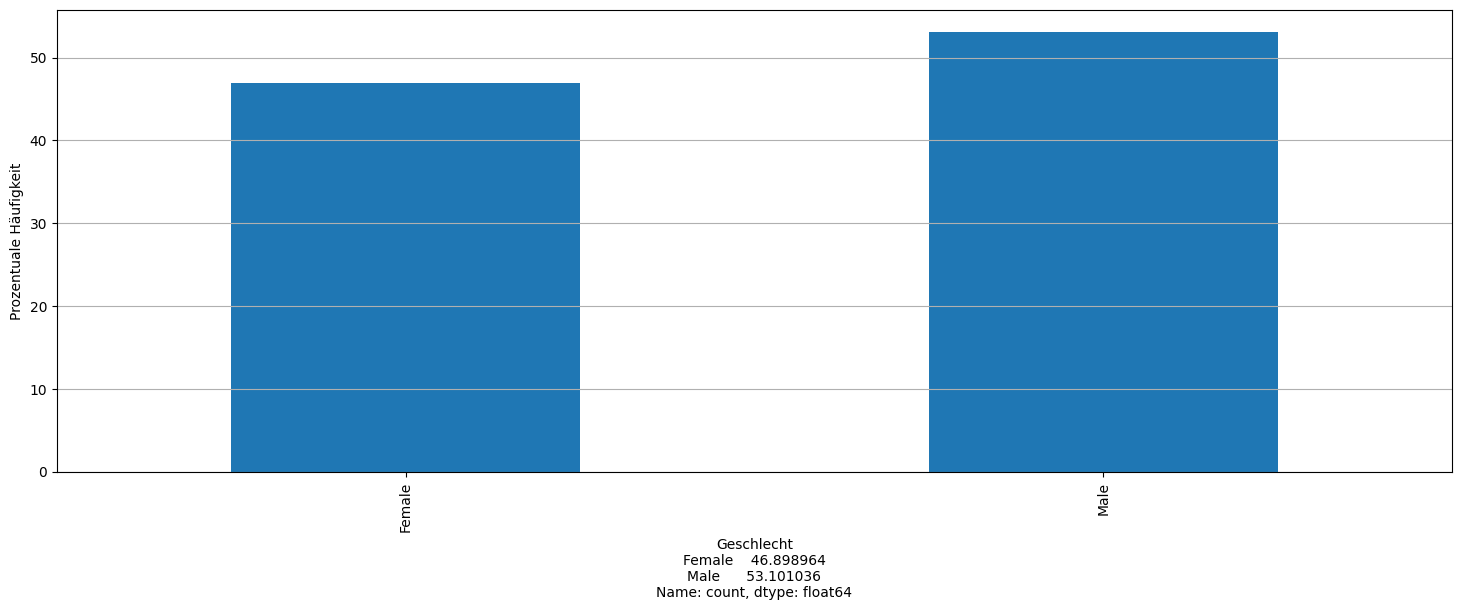

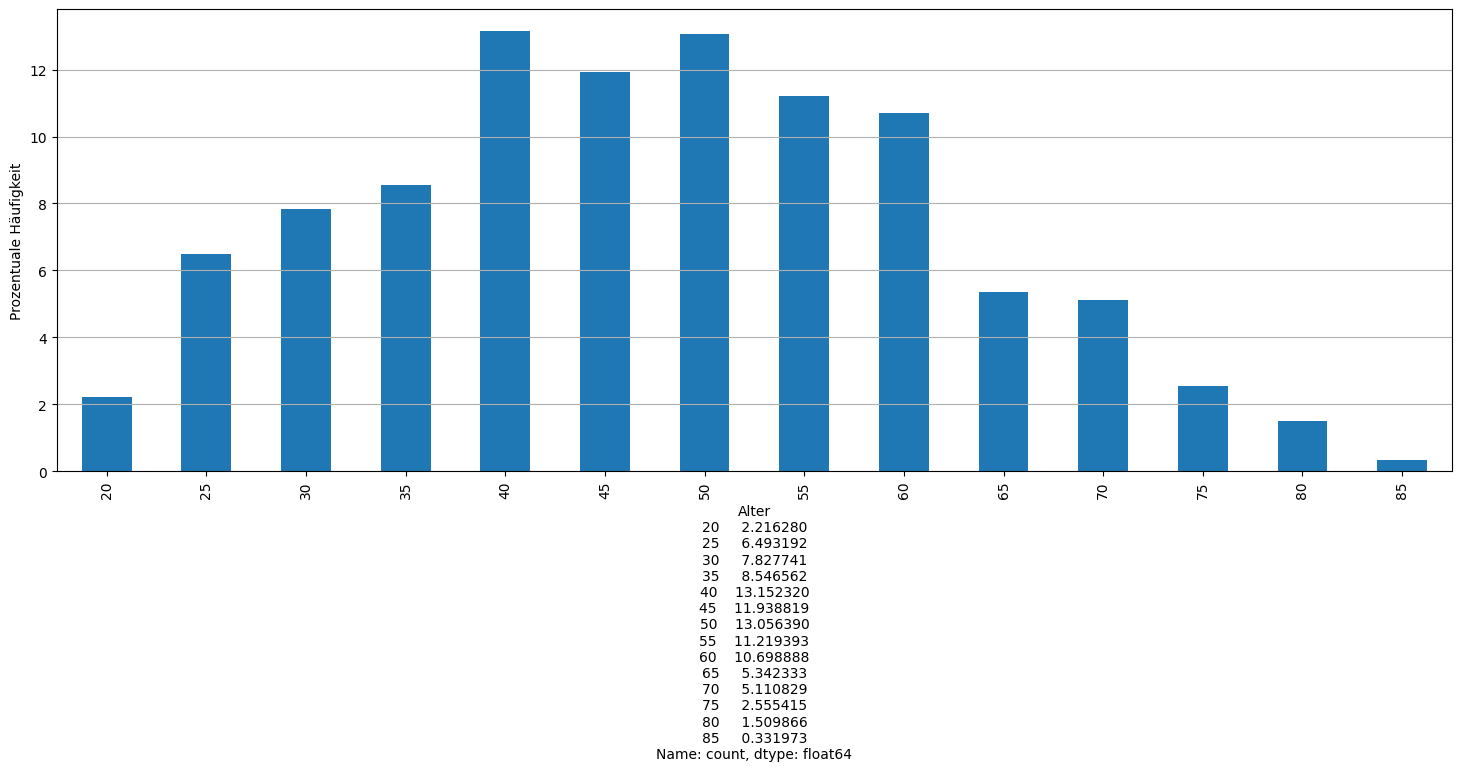

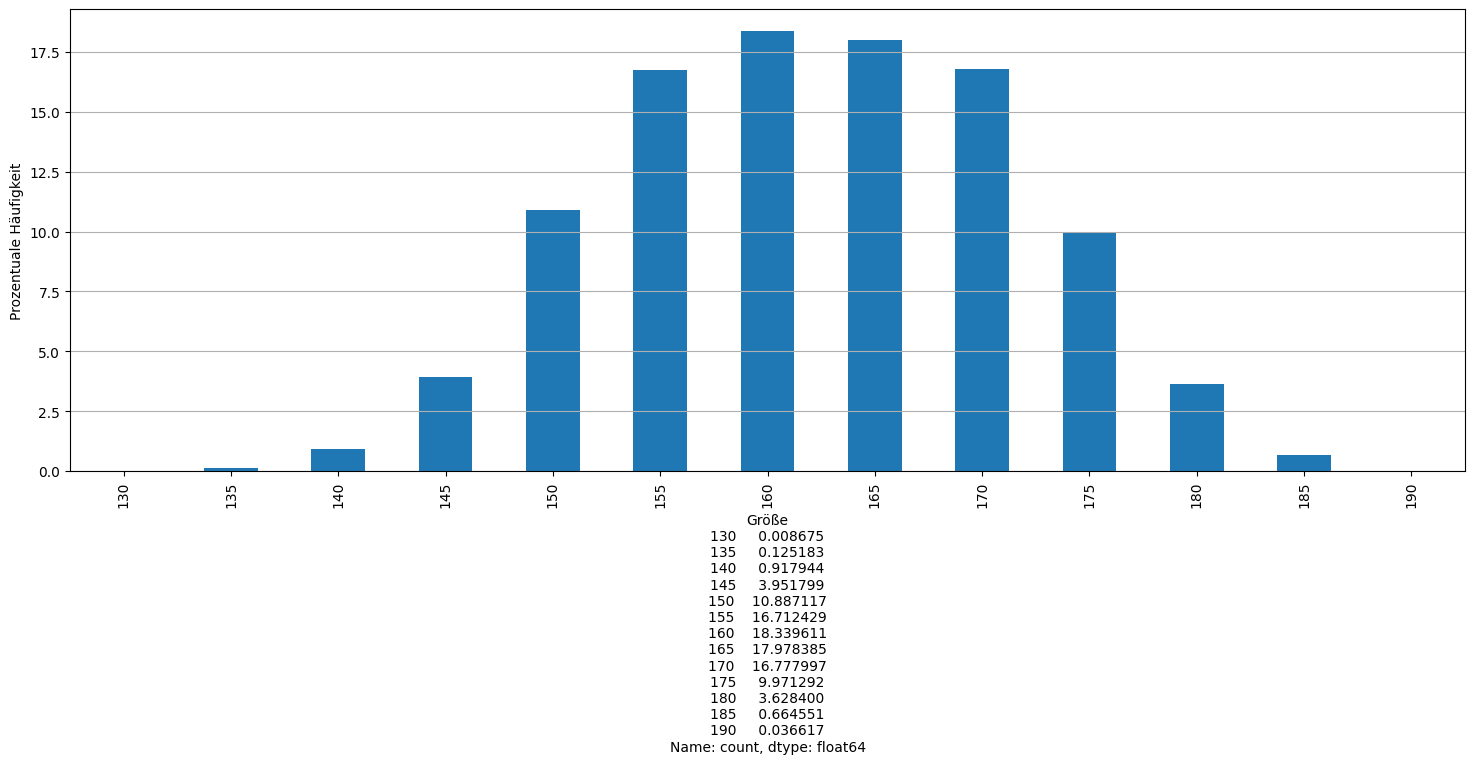

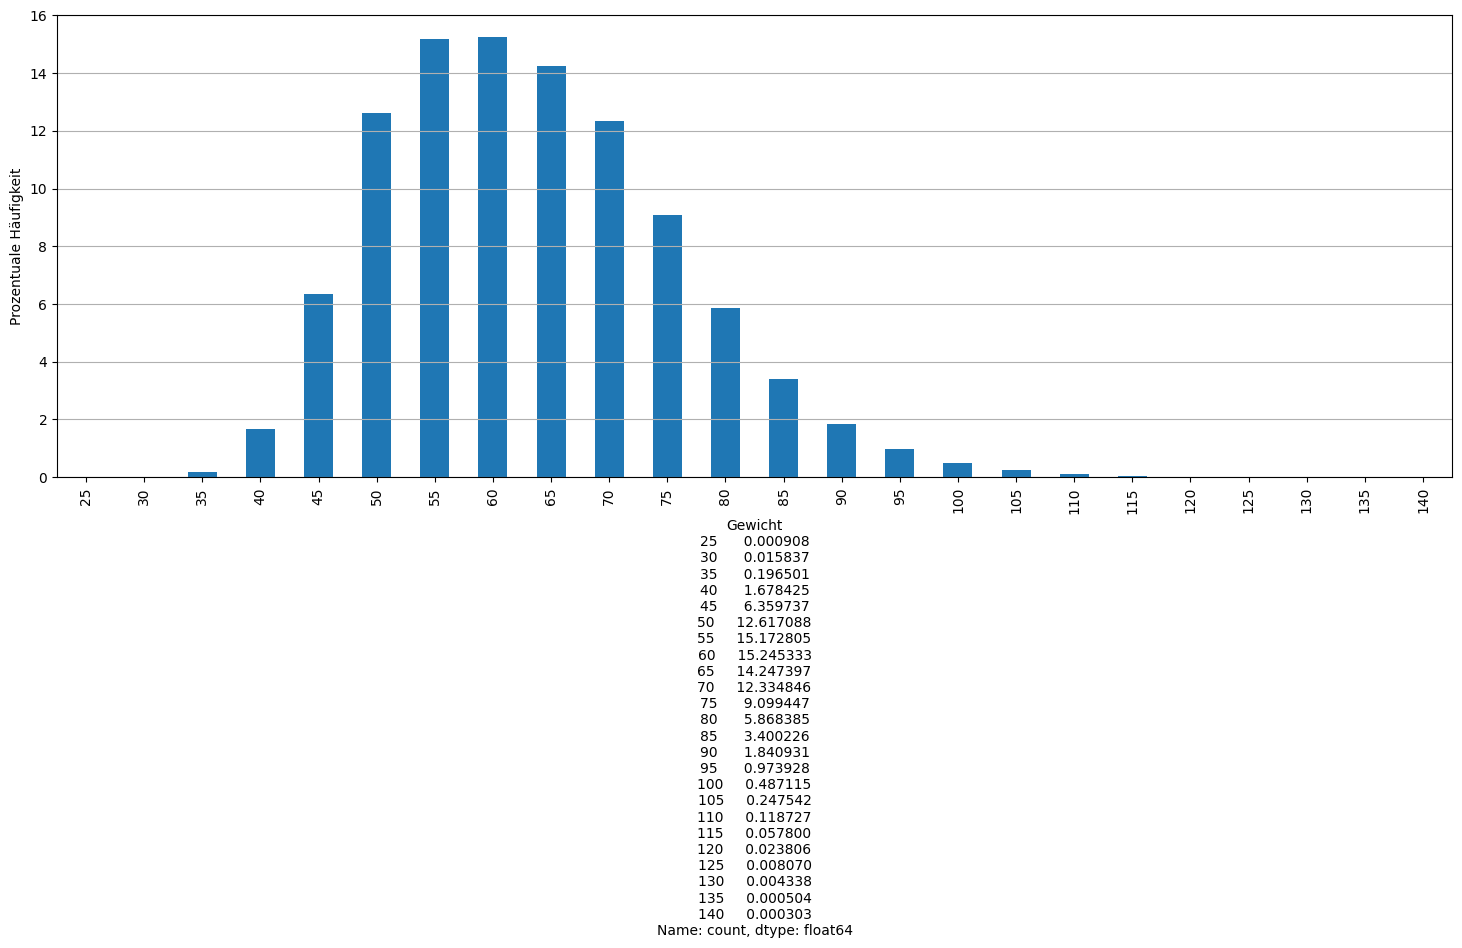

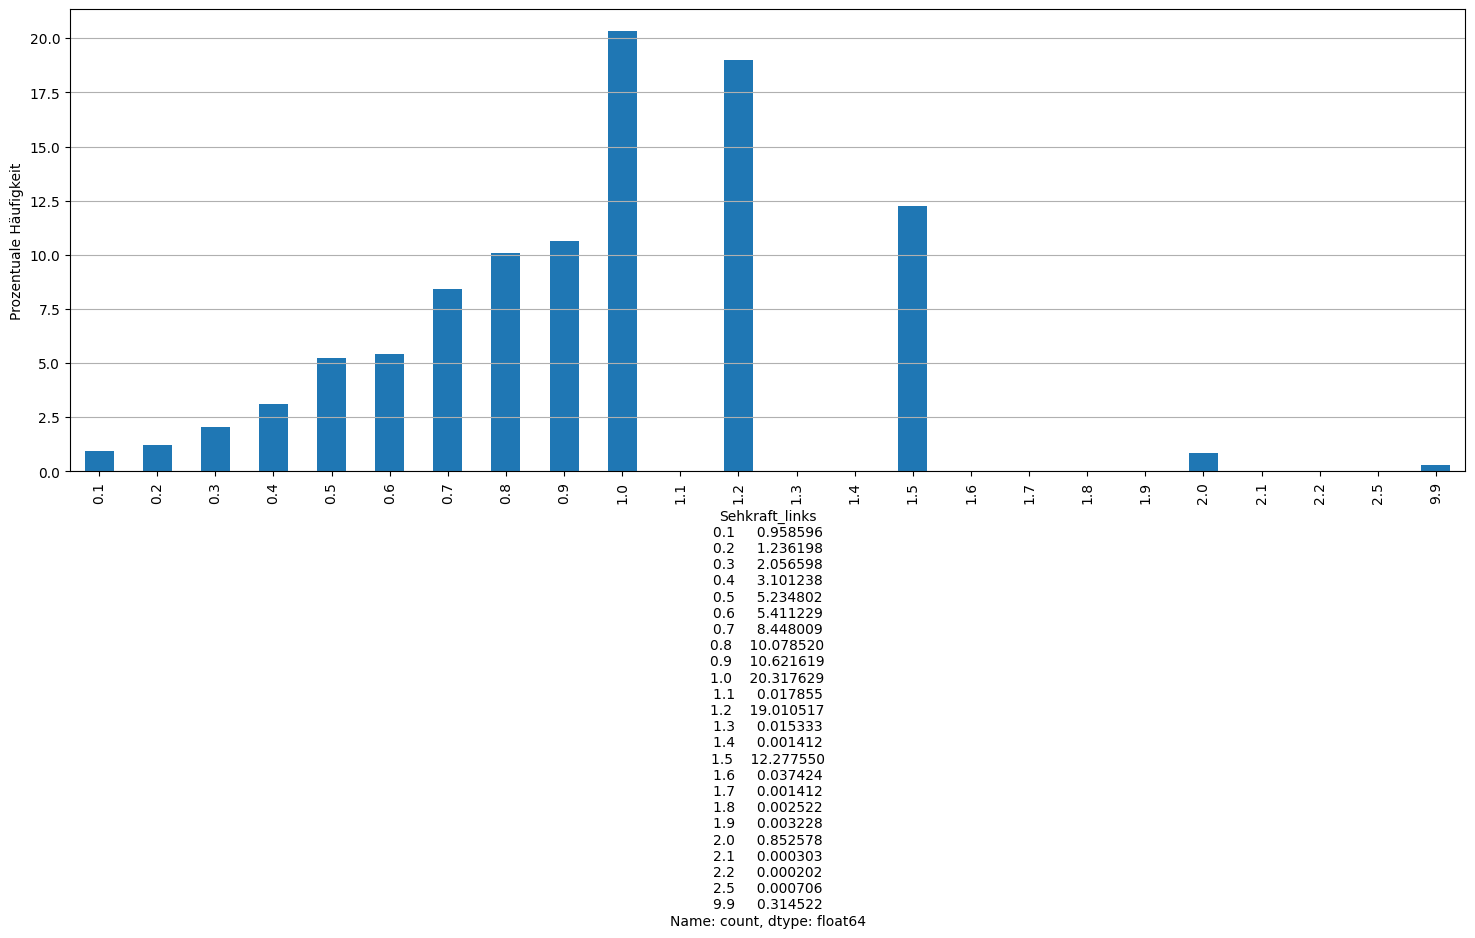

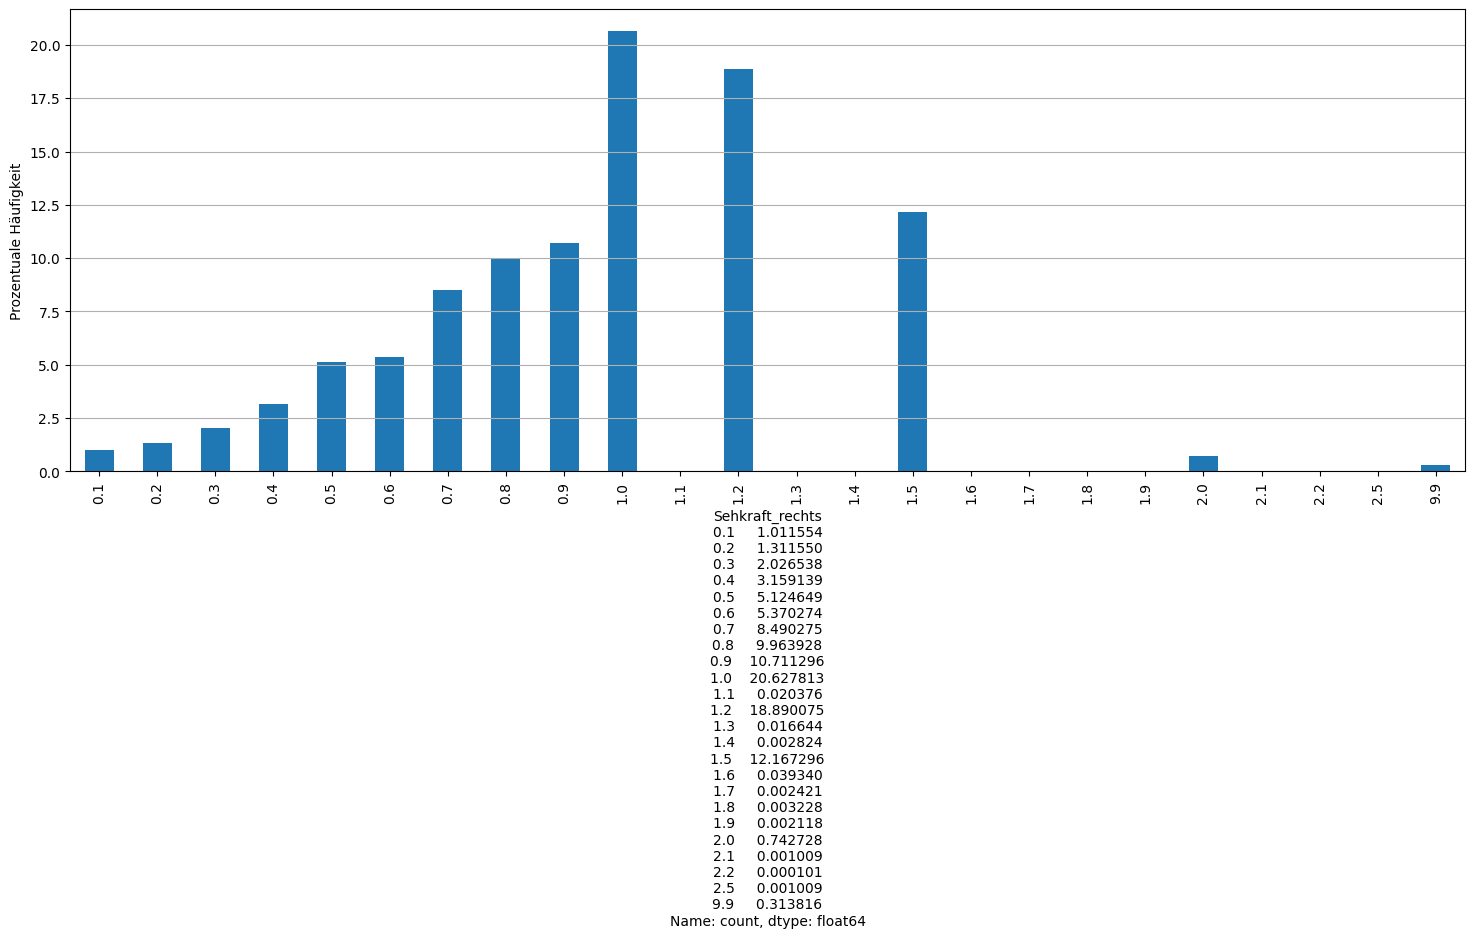

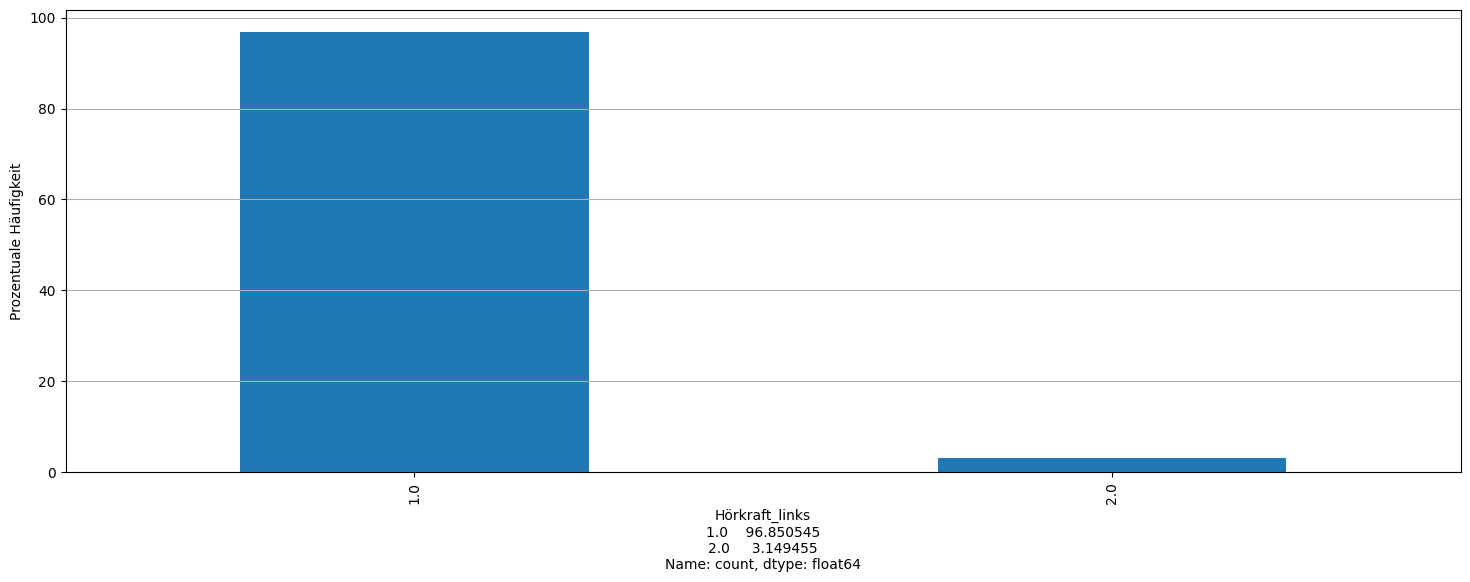

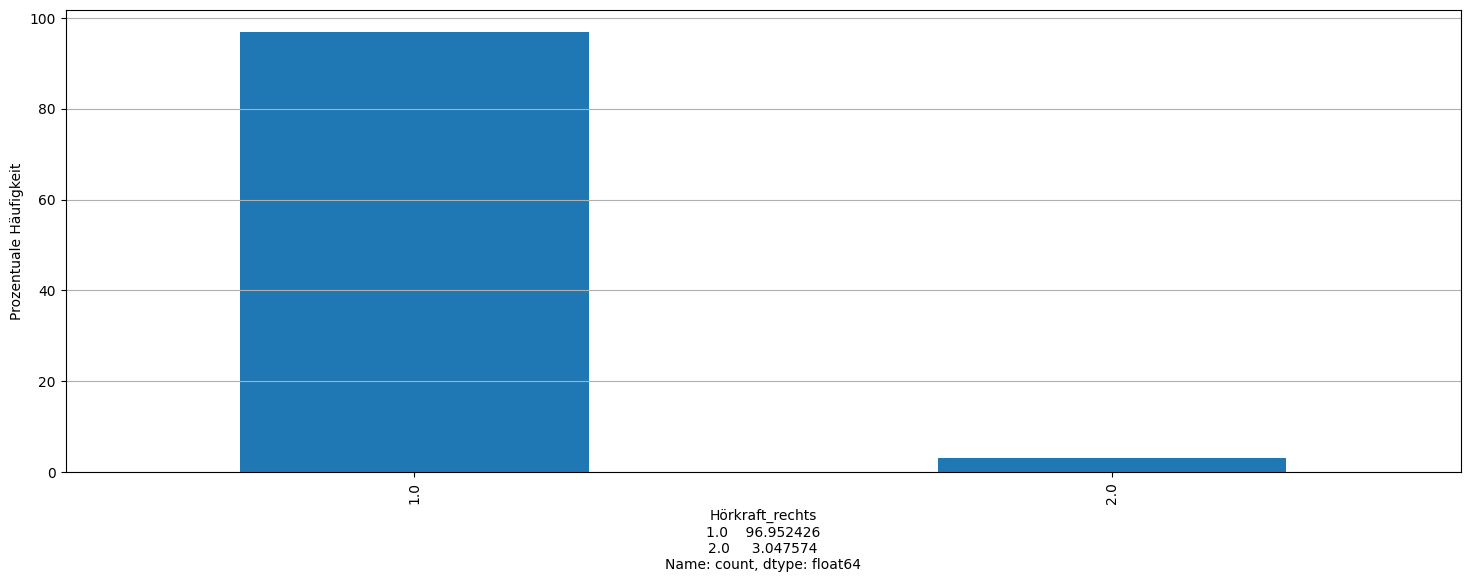

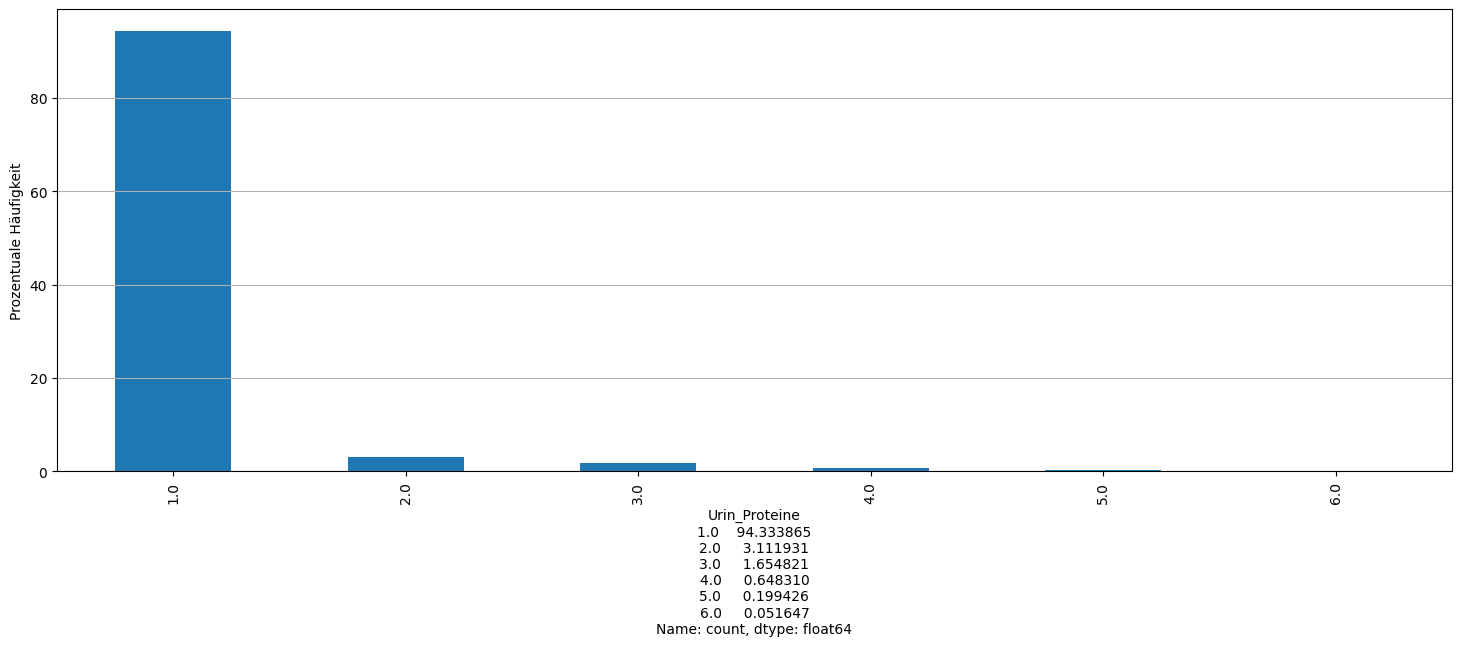

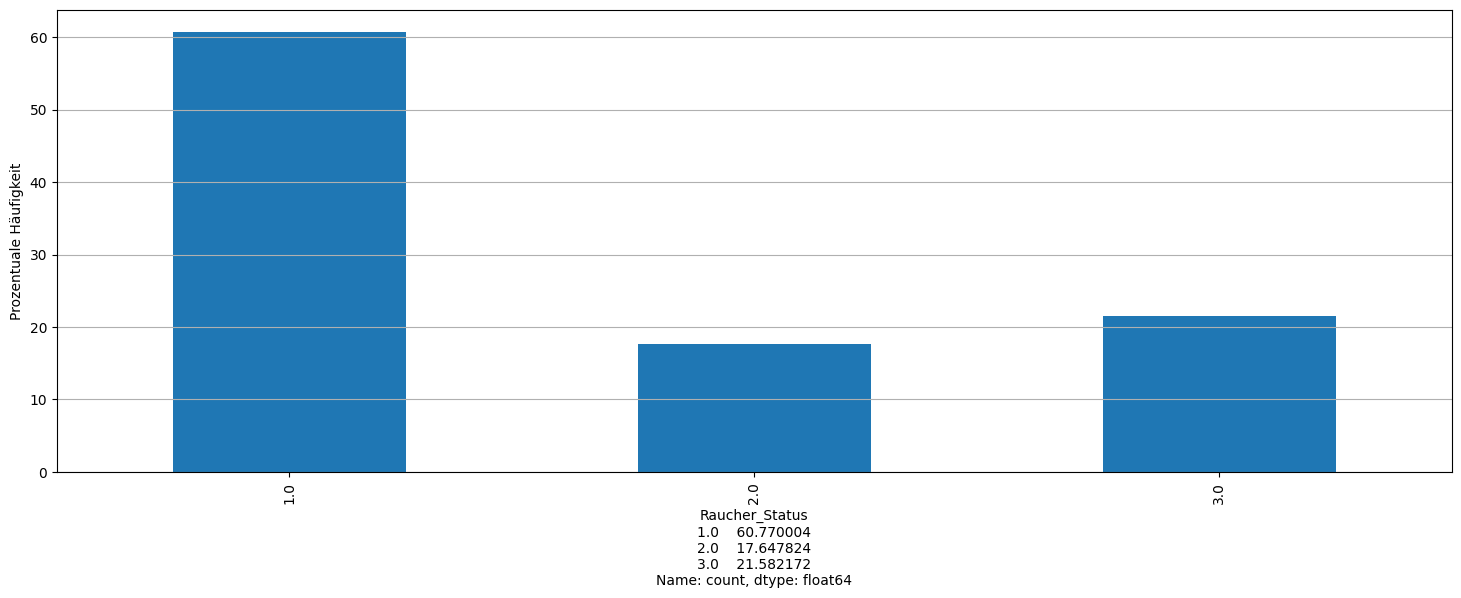

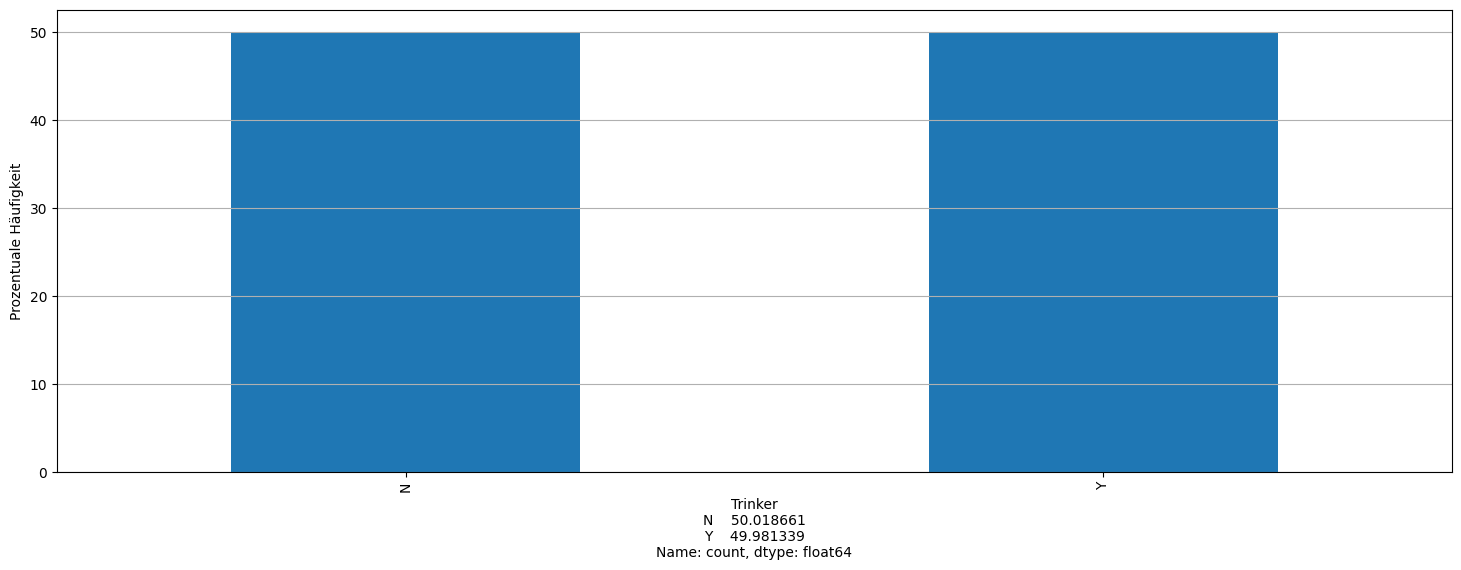

In [8]:
# Darstellen der Verteilung der jeweiligen Spalten:

dataset_columns_less = dataset.loc[:, dataset.apply(pd.Series.nunique) <= 30]

column_names_less = dataset_columns_less.columns.values.tolist()

for column in column_names_less:
    bar_chart(column)

In [9]:
# Funktion zum Darstellen der Verteilung der Werte einer Spalte als Boxplot:

def boxplot_chart(column):
    plt.figure(figsize=(18, 6)) 
    plt.boxplot(dataset[column], vert=False)
    plt.xlabel(column)
    plt.title('Boxplot')
    plt.show()

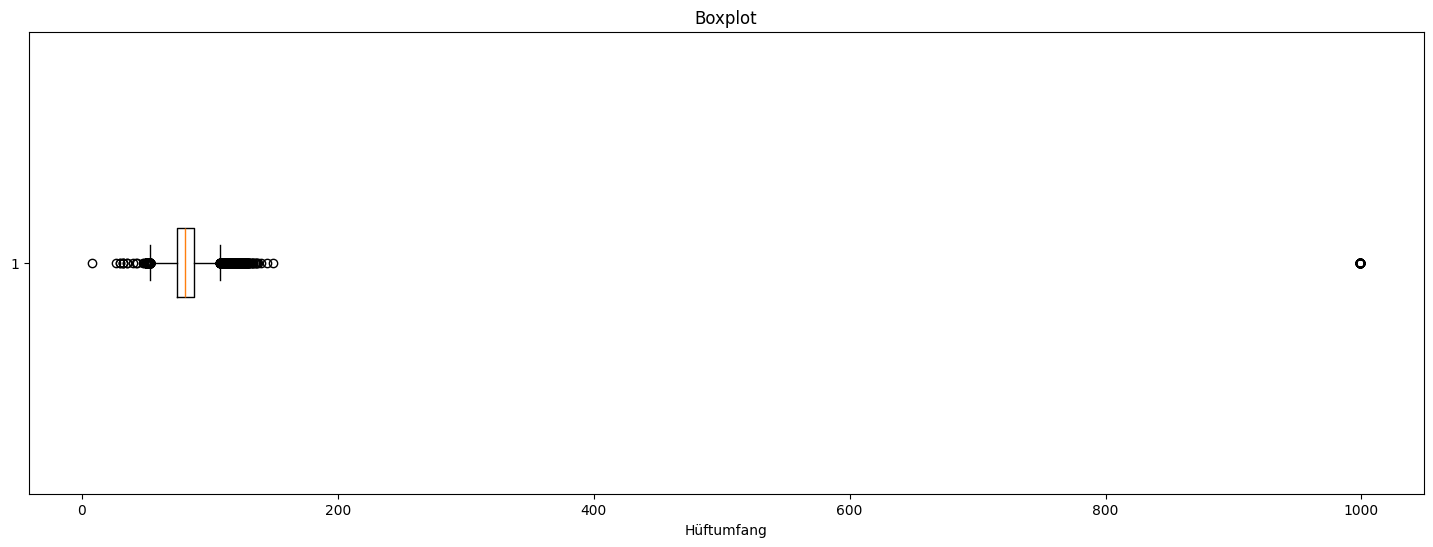

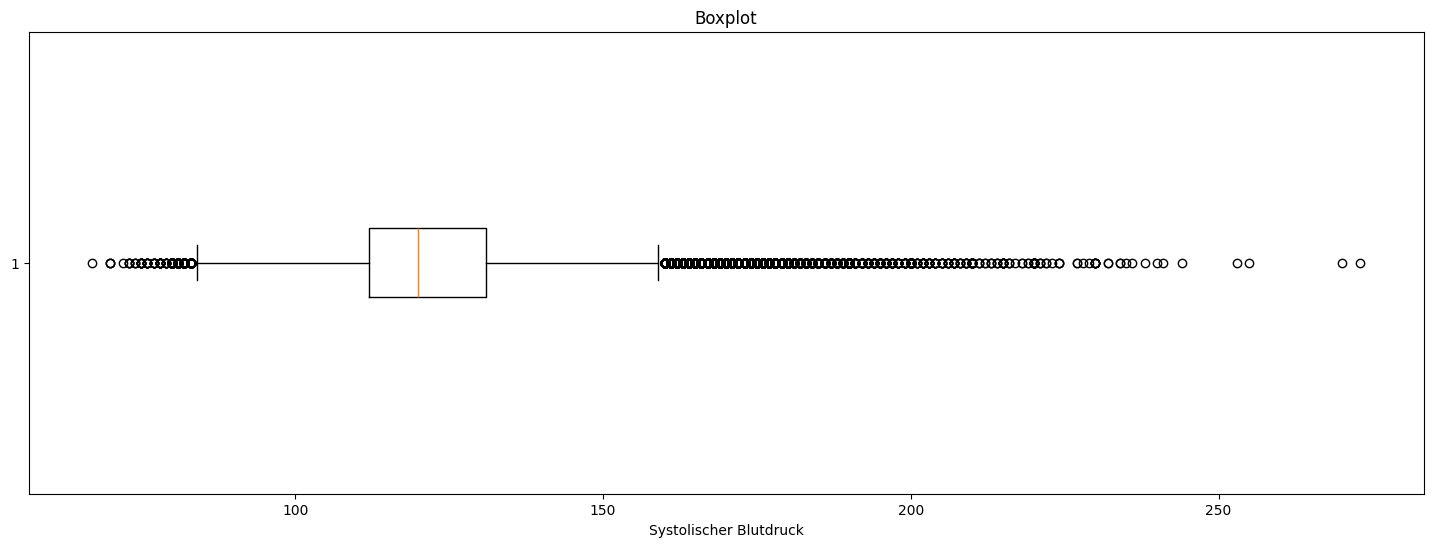

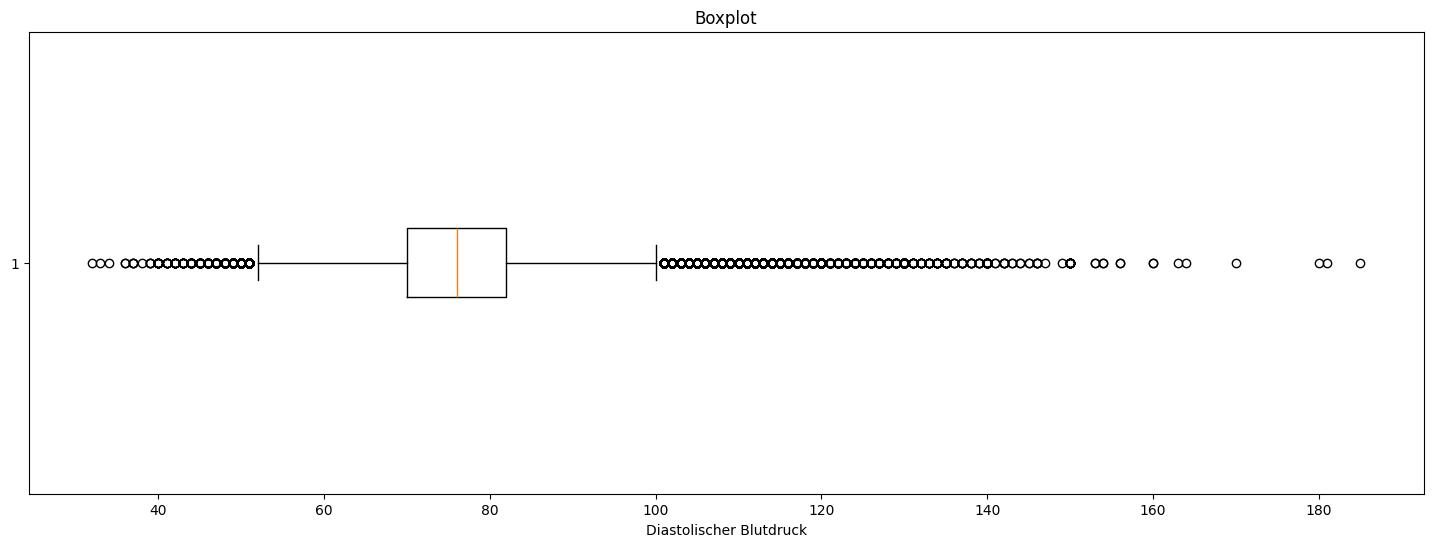

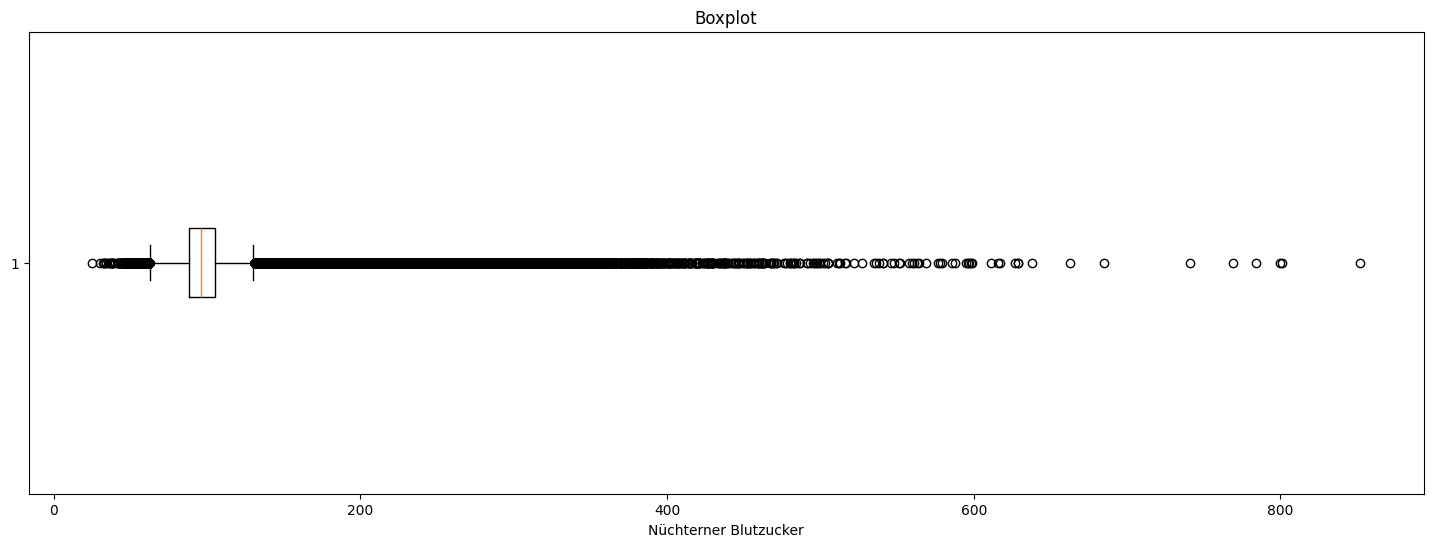

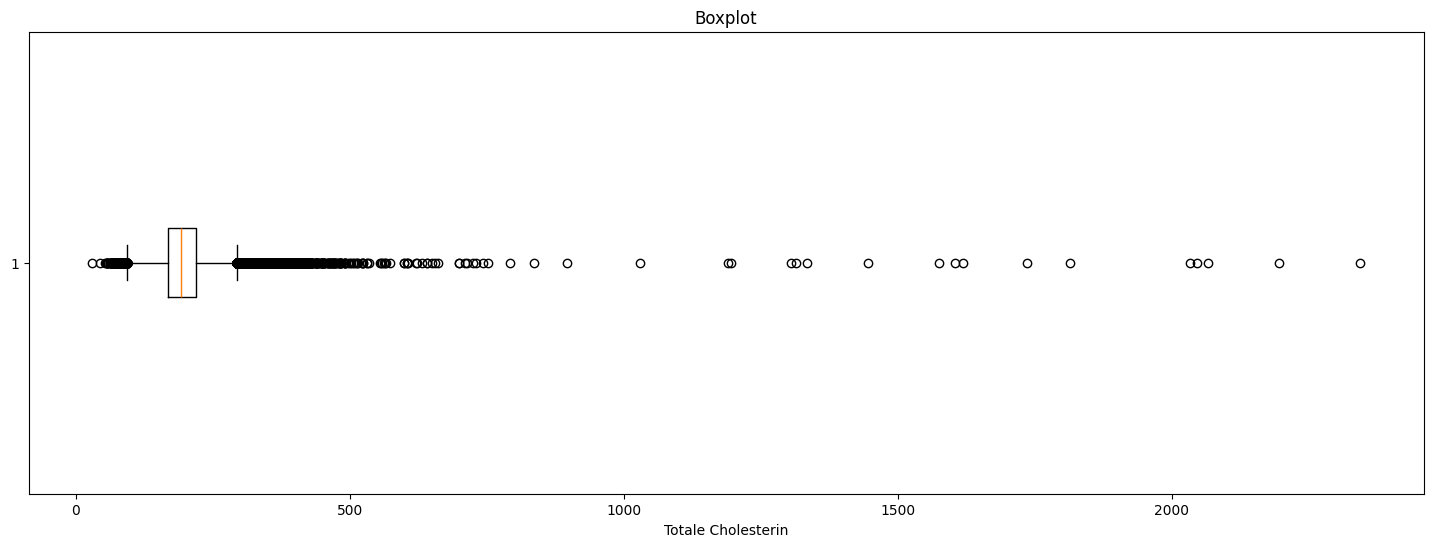

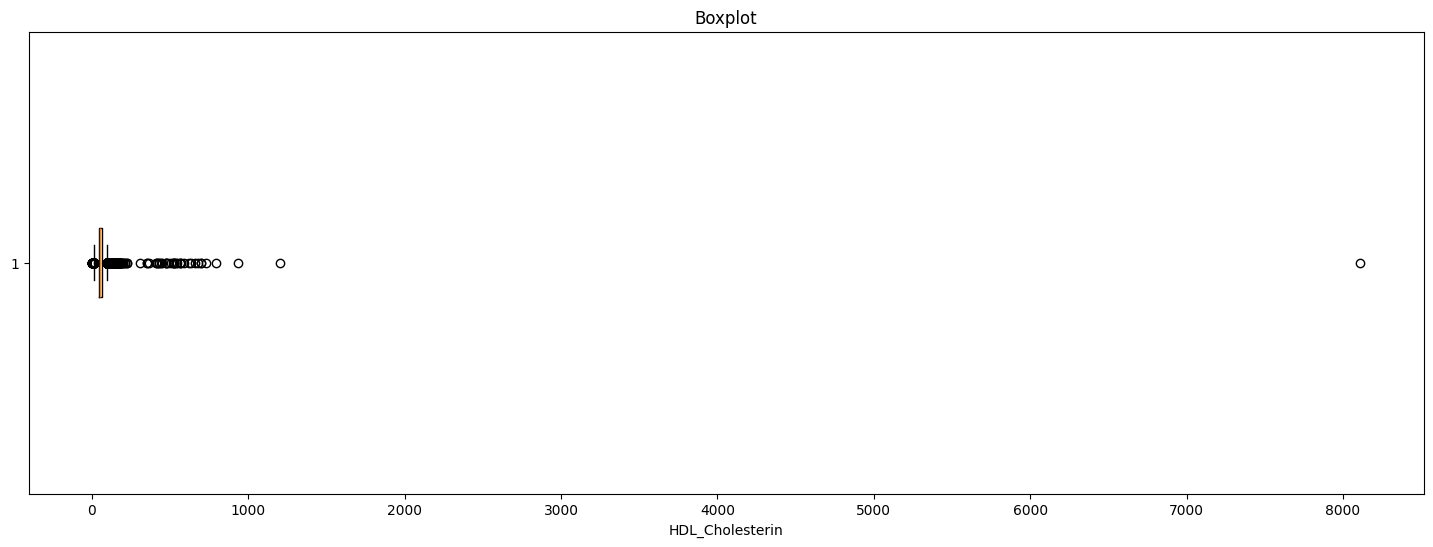

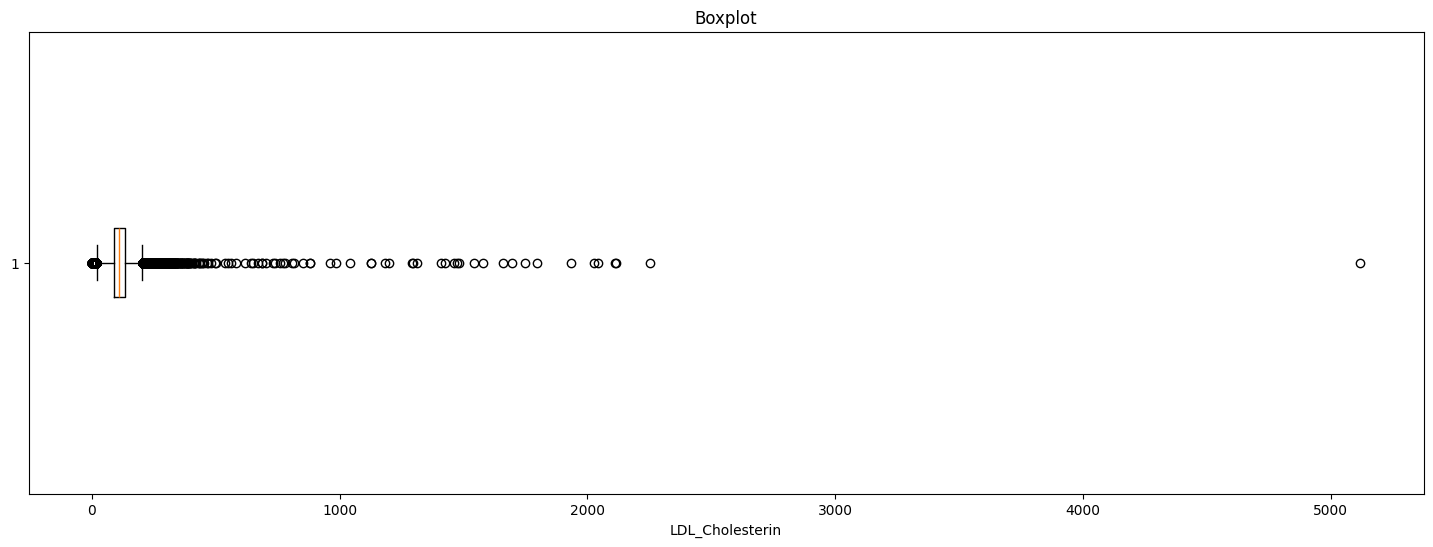

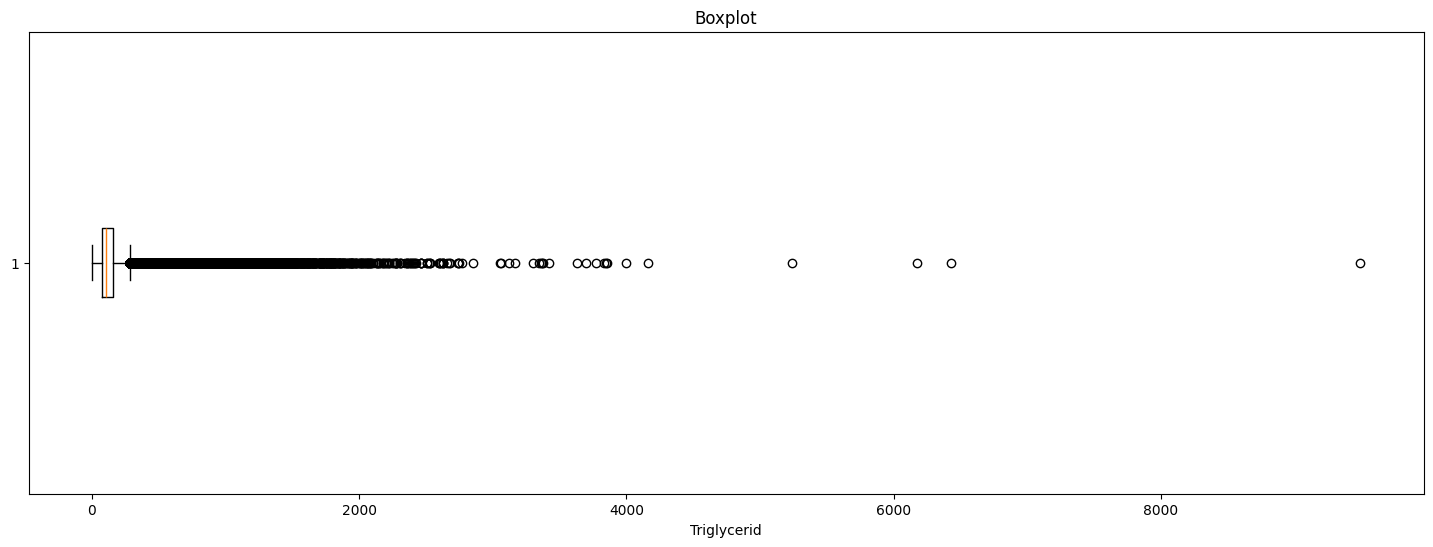

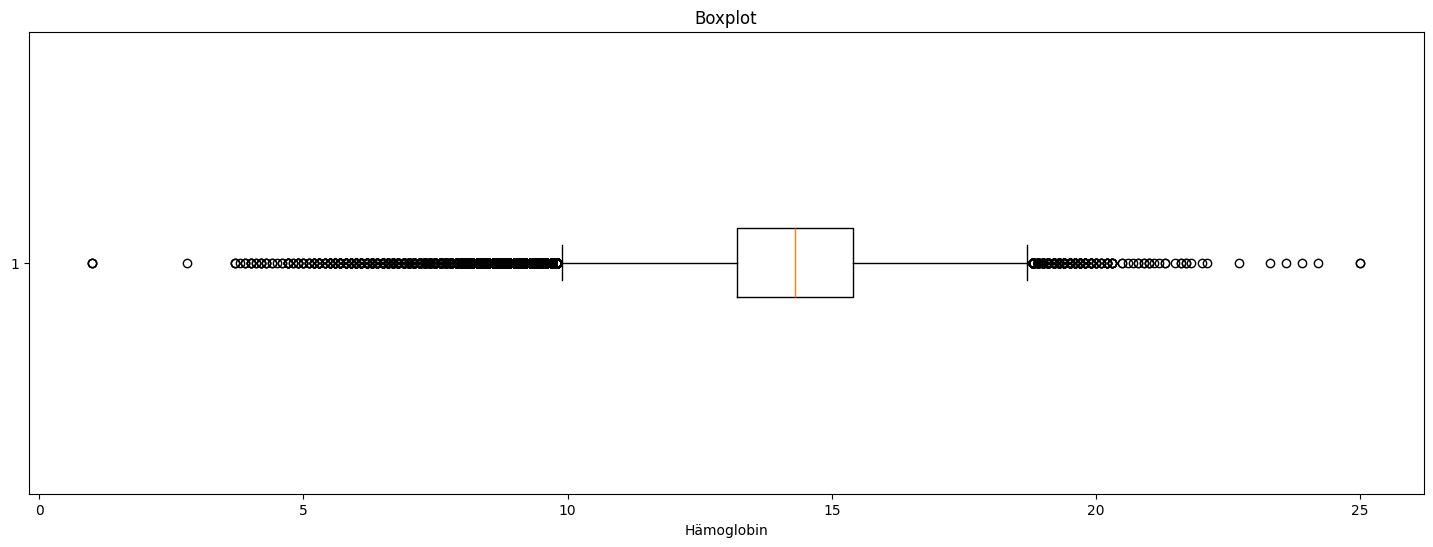

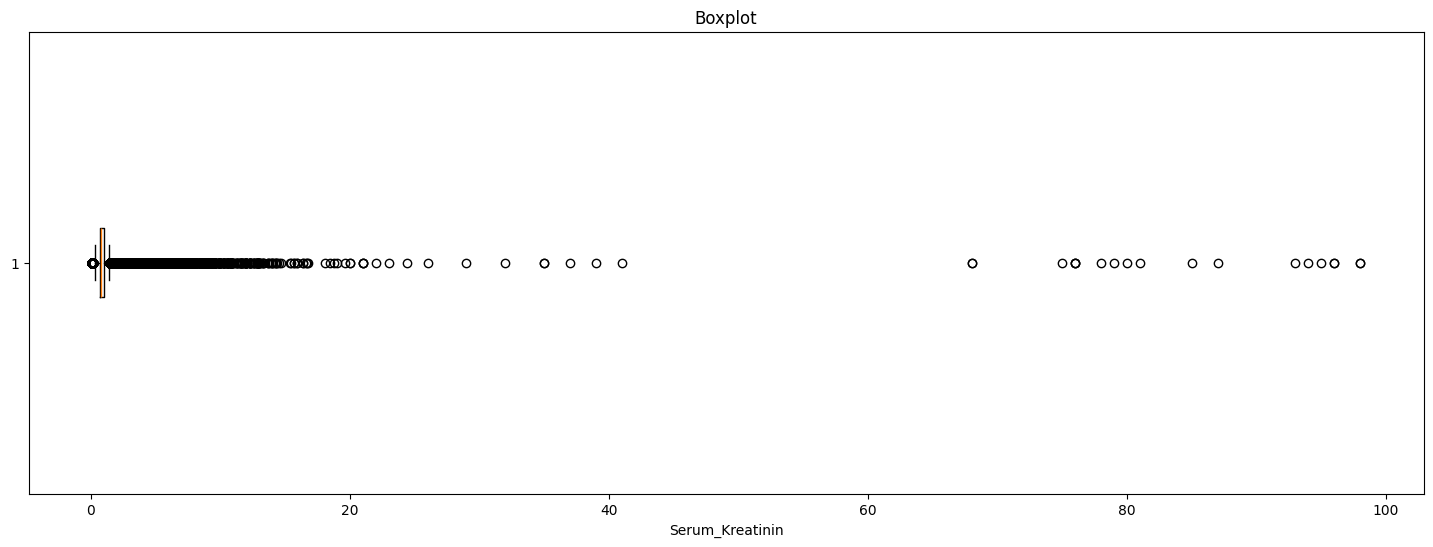

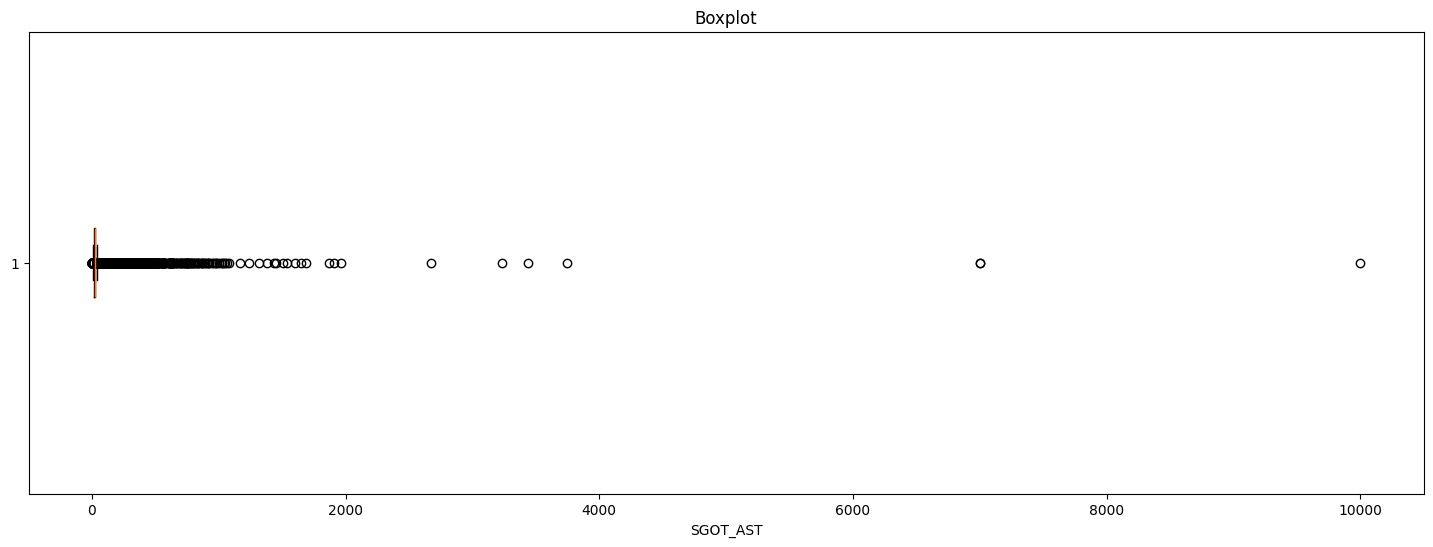

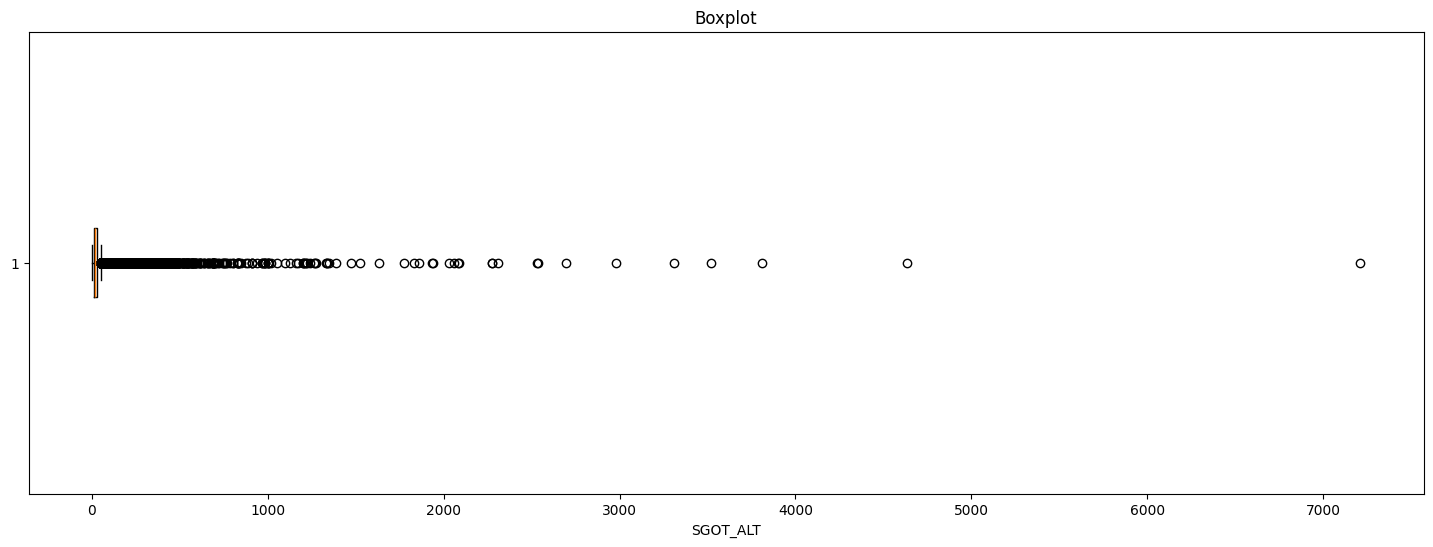

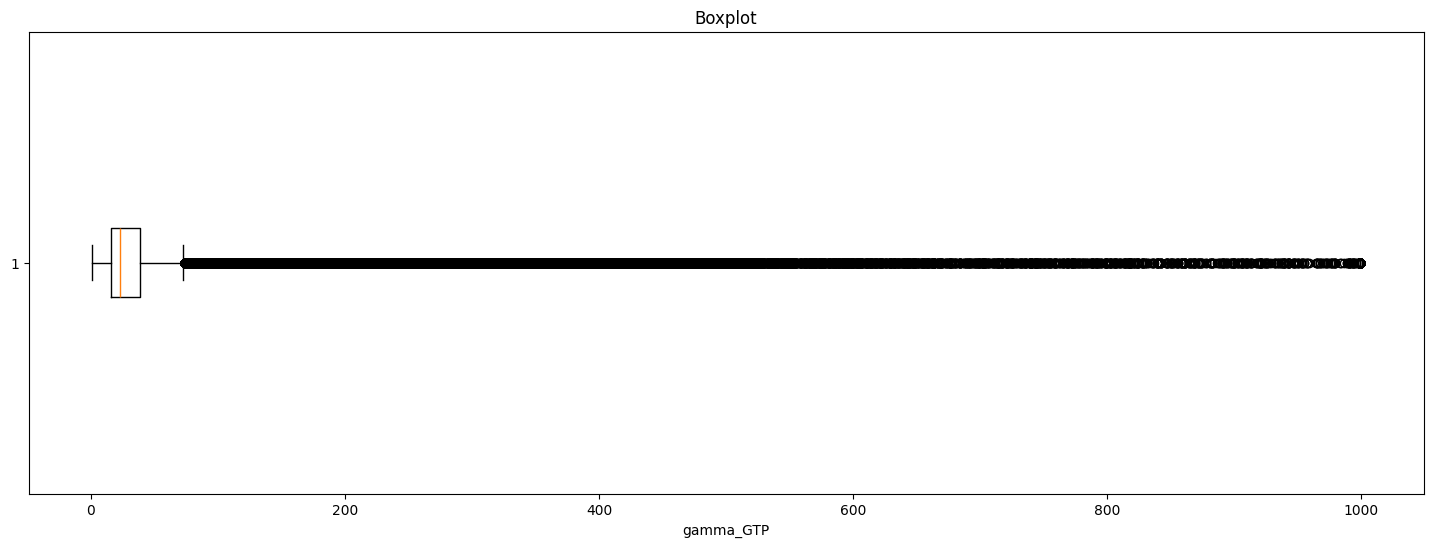

In [10]:
# Darstellen der Verteilung der jeweiligen Spalten:

dataset_columns_more = dataset.loc[:, dataset.apply(pd.Series.nunique) > 30]

column_names_more = dataset_columns_more.columns.values.tolist()

for column in column_names_more:
    boxplot_chart(column)

Die bereits erwähnten Auffälligkeiten zeigen sich auch über die Visualisierung wieder auf.

Diese werden in der Dokumentation genauer erläutert und bei Bedarf im folgenden Abschnitt bereinigt.

## 3. Data Preparation 

Zunächst werden die Datentypen der Spalten Geschlecht und Trinker zu Zahlenwerten transformiert.

In der Spalte Geschlecht nimmt die Ausprägung 'Male' dann den Wert 1 und 'Female' den Wert 0 an.

In der Spalte Trinker wird das 'Y' (für Yes) zu 1 und das 'N' (für No) zu 0.

In [11]:
# Transformieren der Spalte Geschlecht:

dataset['Geschlecht'] = dataset['Geschlecht'] == 'Male'
dataset['Geschlecht'] = dataset['Geschlecht'].astype(int)


# Transformieren der Spalte Trinker:

dataset['Trinker'] = dataset['Trinker'] == 'Y'
dataset['Trinker'] = dataset['Trinker'].astype(int)

Zudem werden hier neue Features definiert und dem Datensatz hinzugefügt.

In [12]:
# Hinzufügen der Spalte Body-Mass-Index:

BMI = dataset["Gewicht"].astype(np.float64) / ((dataset["Größe"].astype(np.float64) / 100) * (dataset["Größe"].astype(np.float64) / 100))

dataset["Body-Mass-Index"] = round(BMI, 2)

Die im Abschnitt Data Understanding identifizierten auffälligen Datenpunkte werden nun bereinigt.

Da unser Datensatz sehr groß ist (991.346 Zeilen), können fehlerhafte Datenpunkte einfach herausgefiltert werden. Dennoch sollte die Anzahl der Datenpunkte betrachtet und evaluiert werden.

In [13]:
# Ausgabe der Anzahl der fehlerhaften Datenpunkte:

print('Anzahl auffällige Datenpunkte Hüftumfang: ' + str(len(dataset[dataset['Hüftumfang'] == 999])))

print('Anzahl auffällige Datenpunkte Sehkraft_links: ' + str(len(dataset[dataset['Sehkraft_links'] == 9.9])))

print('Anzahl auffällige Datenpunkte Sehkraft_rechts: ' + str(len(dataset[dataset['Sehkraft_rechts'] == 9.9])))

# print('Anzahl auffällige Datenpunkte Nüchterner Blutzucker: ' + str(len(dataset[dataset['Nüchterner Blutzucker'] == 999])))

# print('Anzahl auffällige Datenpunkte Totale Cholesterin: ' + str(len(dataset[dataset['Totale Cholesterin'] == 999])))

print('Anzahl auffällige Datenpunkte HDL_Cholesterin: ' + str(len(dataset[dataset['HDL_Cholesterin'] > 3000])))

print('Anzahl auffällige Datenpunkte LDL_Cholesterin: ' + str(len(dataset[dataset['LDL_Cholesterin'] > 3000])))

print('Anzahl auffällige Datenpunkte Triglycerid: ' + str(len(dataset[dataset['Triglycerid'] > 5000])))

print('Anzahl auffällige Datenpunkte Serum_Kreatinin: ' + str(len(dataset[dataset['Serum_Kreatinin'] > 50])))

# print('Anzahl auffällige Datenpunkte gamma_GTP: ' + str(len(dataset[dataset['gamma_GTP'] == 999])))

print('Anzahl auffällige Datenpunkte SGOT_AST: ' + str(len(dataset[dataset['SGOT_AST'] > 3000])))

print('Anzahl auffällige Datenpunkte SGOT_ALT: ' + str(len(dataset[dataset['SGOT_ALT'] > 3000])))

Anzahl auffällige Datenpunkte Hüftumfang: 57
Anzahl auffällige Datenpunkte Sehkraft_links: 3118
Anzahl auffällige Datenpunkte Sehkraft_rechts: 3111
Anzahl auffällige Datenpunkte HDL_Cholesterin: 1
Anzahl auffällige Datenpunkte LDL_Cholesterin: 1
Anzahl auffällige Datenpunkte Triglycerid: 4
Anzahl auffällige Datenpunkte Serum_Kreatinin: 19
Anzahl auffällige Datenpunkte SGOT_AST: 6
Anzahl auffällige Datenpunkte SGOT_ALT: 5


In [14]:
# Ausgabe der Anzahl der fehlerhaften Datenpunkte gesamt:

filter_Hüftumfang = dataset['Hüftumfang'] == 999
filter_Sehkraft_links = dataset['Sehkraft_links'] == 9.9
filter_Sehkraft_rechts = dataset['Sehkraft_rechts'] == 9.9
filter_HDL_Cholesterin = dataset['HDL_Cholesterin'] > 3000
filter_LDL_Cholesterin = dataset['LDL_Cholesterin'] > 3000
filter_Triglycerid = dataset['Triglycerid'] > 5000
filter_Serum_Kreatinin = dataset['Serum_Kreatinin'] > 50
filter_SGOT_AST = dataset['SGOT_AST'] > 3000
filter_SGOT_ALT = dataset['SGOT_ALT'] > 3000

filtered_dataset = dataset[filter_Hüftumfang | filter_Sehkraft_links | filter_Sehkraft_rechts | filter_HDL_Cholesterin | filter_LDL_Cholesterin | filter_Serum_Kreatinin | filter_Triglycerid | filter_SGOT_AST | filter_SGOT_ALT]

print(len(filtered_dataset))

5833


Von den 991.346 Zeilen werden somit lediglich 5.833 herausgefiltert.

In [15]:
# Ausgabe der Anzahl der fehlerhaften Datenpunkte gesamt:

filter_Hüftumfang = dataset['Hüftumfang'] != 999
filter_Sehkraft_links = dataset['Sehkraft_links'] != 9.9
filter_Sehkraft_rechts = dataset['Sehkraft_rechts'] != 9.9
filter_HDL_Cholesterin = dataset['HDL_Cholesterin'] <= 3000
filter_LDL_Cholesterin = dataset['LDL_Cholesterin'] <= 3000
filter_Triglycerid = dataset['Triglycerid'] <= 5000
filter_Serum_Kreatinin = dataset['Serum_Kreatinin'] <= 50
filter_SGOT_AST = dataset['SGOT_AST'] <= 3000
filter_SGOT_ALT = dataset['SGOT_ALT'] <= 3000

dataset = dataset[filter_Hüftumfang & filter_Sehkraft_links & filter_Sehkraft_rechts & filter_HDL_Cholesterin & filter_LDL_Cholesterin & filter_Serum_Kreatinin & filter_Triglycerid & filter_SGOT_AST & filter_SGOT_ALT]

print(len(dataset))

985513


Nun müsste der Datensatz erneut auf Auffälligkeiten untersucht werden, um zu validieren, dass alle fehlerhaften Daten eliminiert wurde.

Im Rahmen der Umsetzung der Anforderungen erfolgte dieser Schritt iterativ, bis wir zum hier dargestellten Punkt kamen. Deshalb wird auf einen erneuten iterativen Ansatz innerhalb dieser Projektmappe verzichtet. 

Da es in diesem Use-Case um die Klassifizierung der Raucher geht, können zudem Spalten eliminiert werden, die nicht mit diesem Feature korrelieren.

Durch die Transformation der Datentypen der Spalten Geschlecht und Trinker kann folgend eine Korrelationsmatrix dargestellt werden.

In [16]:
# Funktion zum Darstellen der Korrelation der Werte mehrerer Spalten:

def corrmap(columns):
    plt.figure(figsize=(20, 18))
    data = dataset[columns]
    sns.heatmap(data.corr(), annot=True, cmap="coolwarm")

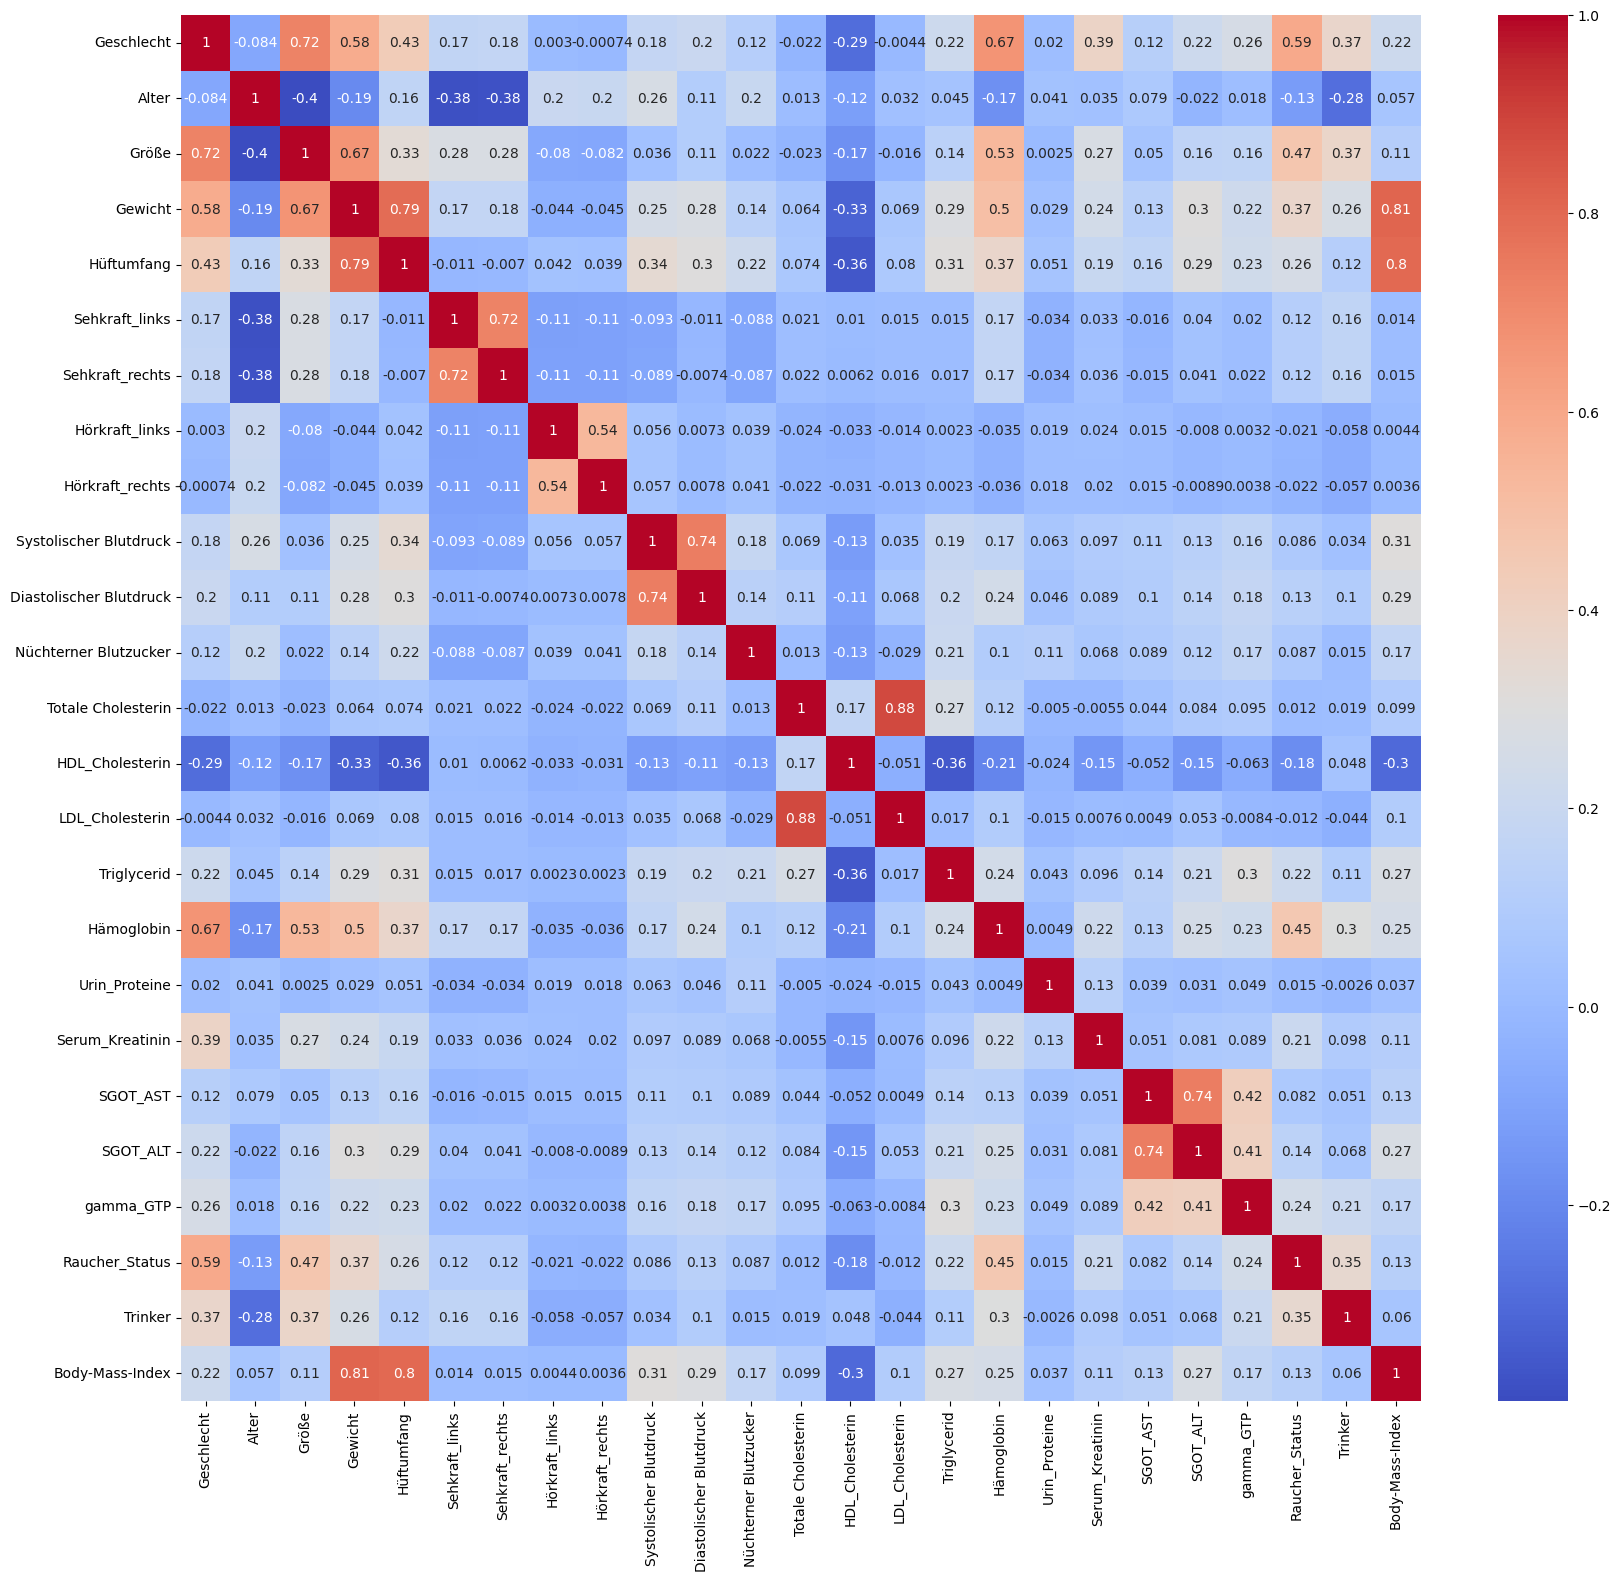

In [17]:
column_names = dataset.columns.values.tolist()

corrmap(column_names)

Die folgenden Spalten korrelieren nur sehr gering mit dem Feature Raucher_Status und werden deshalb eliminiert.

- Sehkraft_links 
- Sehkraft_rechts 
- Hörkraft_links 
- Hörkraft_rechts 
- Systolischer Blutdruck 
- Diastolischer Blutdruck 
- Nüchterner Blutzucker 
- Totale Cholesterin 
- HDL_Cholesterin 
- LDL_Cholesterin 
- Urin_Proteine 
- Serum_Kreatinin 
- SGOT_AST 
- SGOT_ALT 
- Body-Mass-Index

In [18]:
# Eliminieren der Spalten:

dataset = dataset.drop(columns=['Sehkraft_links', 'Sehkraft_rechts', 'Hörkraft_links', 'Hörkraft_rechts', 'Systolischer Blutdruck', 'Diastolischer Blutdruck', 'Nüchterner Blutzucker', 'Totale Cholesterin', 'HDL_Cholesterin', 'LDL_Cholesterin', 'Urin_Proteine', 'Serum_Kreatinin', 'SGOT_AST', 'SGOT_ALT', 'Body-Mass-Index'])

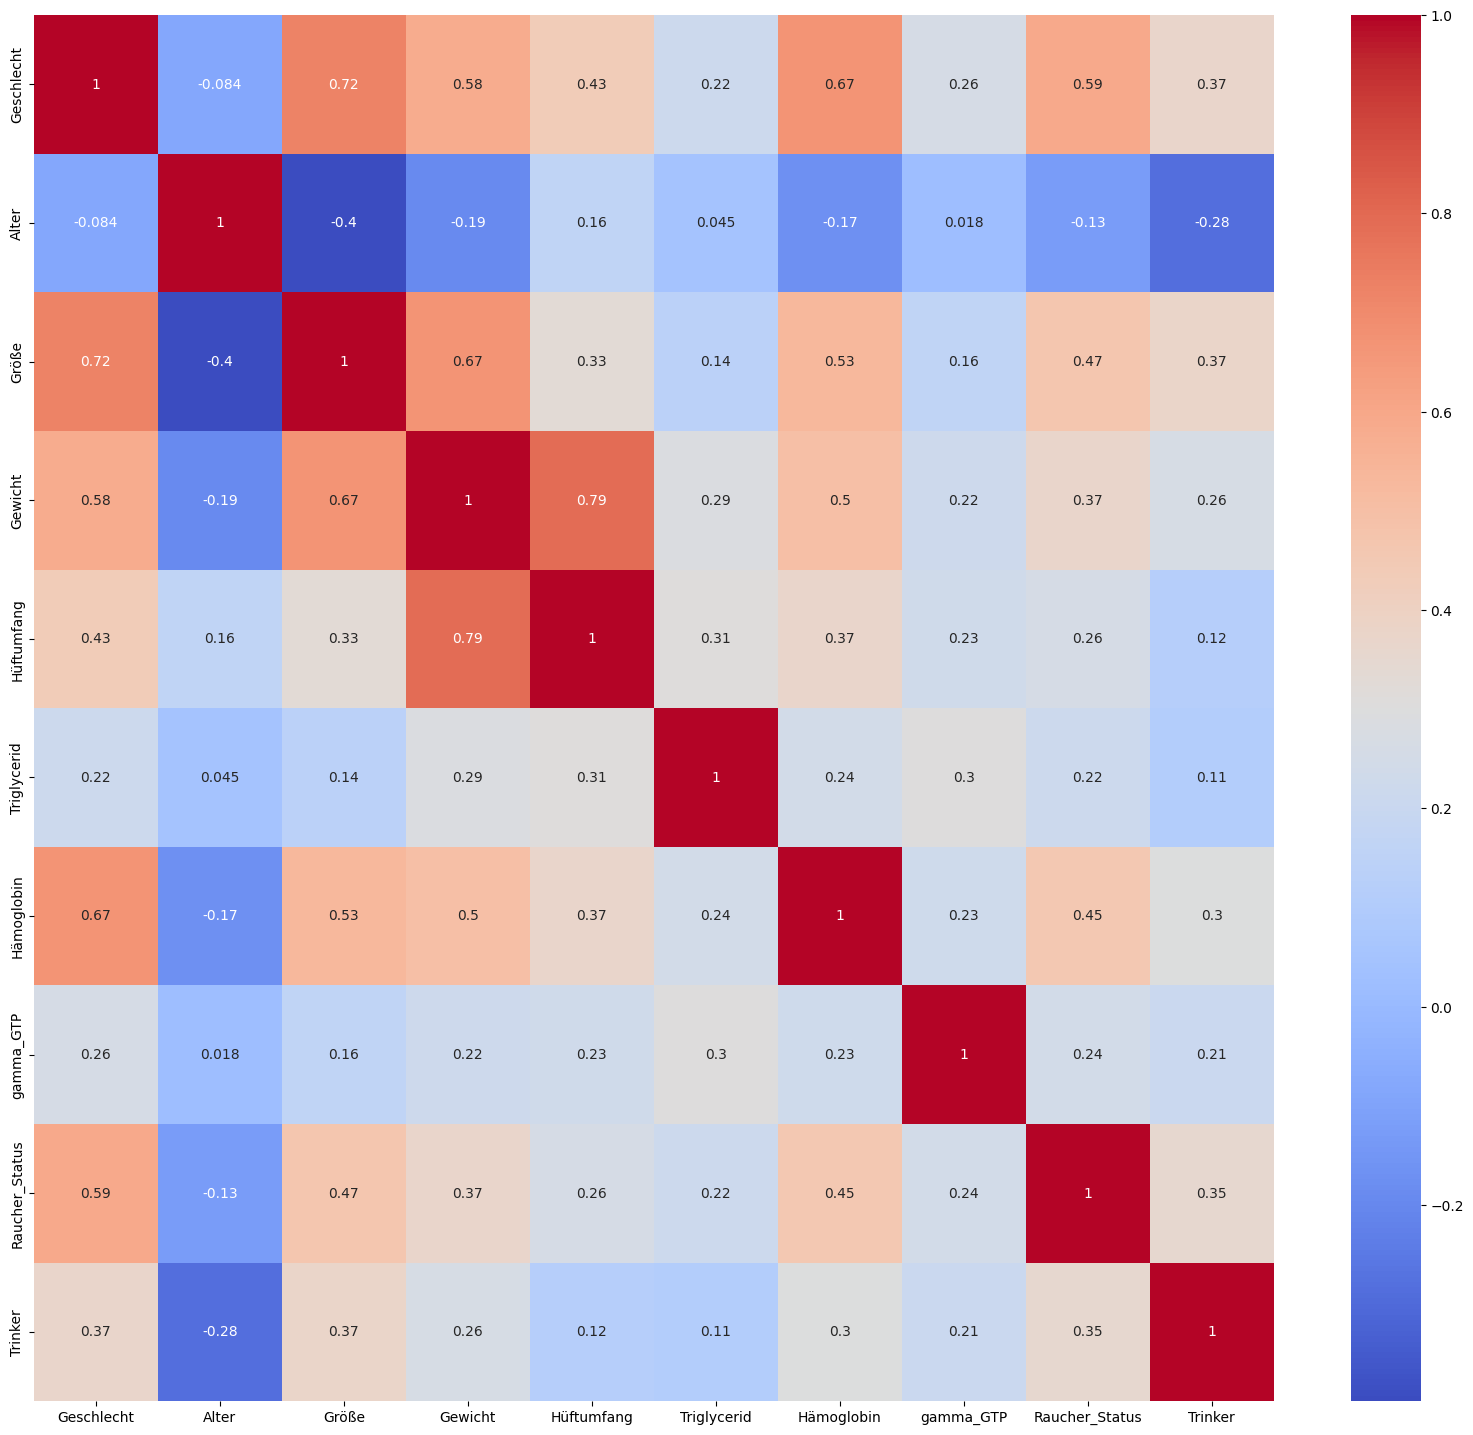

In [19]:
# Erneute Darstellung der Korrelation:

column_names = dataset.columns.values.tolist()

corrmap(column_names)

Nun sollten die Datensätze erneut auf Auffälligkeiten geprüft werden.

Im Rahmen dieser Projektarbeit verlief der gesamte Entwicklungsprozess iterativ. Dies hier darzustellen würde jedoch für eine unübersichtliche Struktur sorgen, weshalb darauf verzichtet wird.

Das Geschlecht ist mit einer Korrelation zum Raucher_Status mit 0,59 ein wesentlicher Einfluss auf diesen. Es wird somit auch im Klassifikationsalgorithmus berücksichtigt, wodurch eine Aufteilung der Daten auf Männer und Frauen für dieses Modell nicht notwendig ist.

## 4. Modeling

Aus der Sicht einer Versicherung besteht bei ehemaligen Rauchern ein nahezu gleiches Gesundheitsrisiko wie bei aktiven Rauchern.

Für die Einordnung der Kunden in Versicherungskohorten ergibt es sich deshalb, diese Raucherstati zusammenzulegen.

In [20]:
# Vereinheitlichung der Raucherstati 2 (ehemalige Raucher) & 3 (aktive Raucher):

dataset['Raucher_Status'] = dataset['Raucher_Status'].replace(3,2)

Zunächst wird hier die Verteilung der Zielklassen betrachtet, um ein eventuell benötigtes Resampling festzustellen.

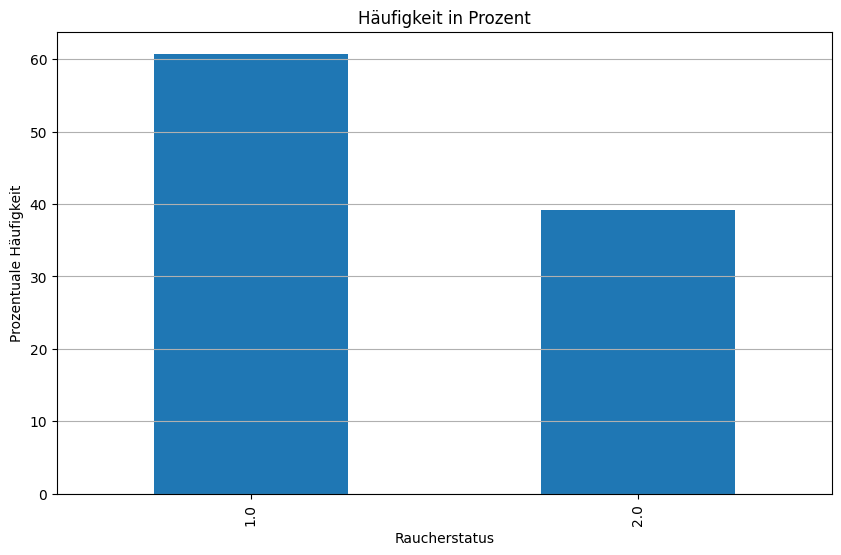

In [21]:
# Berechne relative Häufigkeit der Zielwerte in Prozent 

frequency = (dataset['Raucher_Status'].sort_values().value_counts(sort=False) / len(dataset)) * 100 

# Balkendiagramm über die Verteilung 

plt.figure(figsize=(10, 6)) 
frequency.plot(kind='bar') 
plt.xlabel('Raucherstatus') 
plt.ylabel('Prozentuale Häufigkeit') 
plt.title('Häufigkeit in Prozent') 
plt.grid(axis='y') 
plt.show()

Der Anteil an Nicht-Rauchern ist rund 50 % größer als der Anteil der aktiven und ehemaligen Rauchern, weshalb die Daten folgend durch eine Undersampling bereinigt werden.

Dieses Undersampling minimiert zudem das Rauschen in den Daten.

Random under-sampling:
Raucher_Status
1.0    386665
2.0    386665
Name: count, dtype: int64


<Axes: title={'center': 'Anzahl je Raucher_Status'}, xlabel='Raucher_Status'>

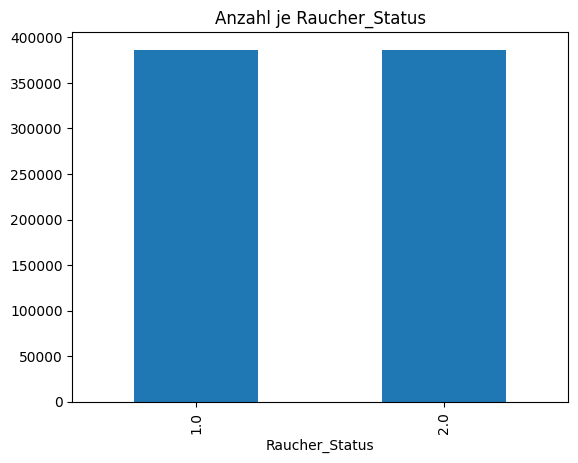

In [22]:
# Undersampling der Daten:

count_class_0, count_class_1 = dataset['Raucher_Status'].sort_values().value_counts()

# Aufteilen in Zielklassen:

class_0 = dataset[dataset['Raucher_Status'] == 1]
class_1 = dataset[dataset['Raucher_Status'] == 2]


class_0_under = class_0.sample(count_class_1)
data_undersample = pd.concat([class_0_under, class_1], axis=0)

print('Random under-sampling:')
print(data_undersample['Raucher_Status'].value_counts())

data_undersample['Raucher_Status'].value_counts().plot(kind='bar', title='Anzahl je Raucher_Status')

In [24]:
# Aufteilen der Daten in Trainings- und Testdaten:

X_train, X_test, y_train, y_test = train_test_split(data_undersample.drop(columns=['Raucher_Status']), data_undersample['Raucher_Status'], test_size=0.2, random_state=42)

X_train

,Geschlecht,Alter,Größe,Gewicht,Hüftumfang,Triglycerid,Hämoglobin,gamma_GTP,Trinker
937286,1,30,180,70,86.2,39.0,14.3,14.0,0
604193,0,65,150,60,86.0,141.0,13.3,26.0,0
985578,0,60,150,45,76.0,182.0,13.9,25.0,0
78130,1,30,170,75,79.0,50.0,16.1,39.0,0
740980,0,70,145,70,91.1,111.0,14.3,25.0,0
...,...,...,...,...,...,...,...,...,...
831684,0,40,155,55,75.0,58.0,12.2,11.0,0
339596,0,70,150,55,89.0,206.0,12.9,10.0,0
826909,0,50,155,50,67.0,86.0,13.4,26.0,0
729267,1,45,160,60,77.0,216.0,16.4,15.0,0


Nun kann das Modell trainiert und die Modellmetriken ausgewertet werden.

In [25]:
softmax_model = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=1000)
softmax_model.fit(X_train, y_train)

c:\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial', solver='saga')

Accuracy: 0.83


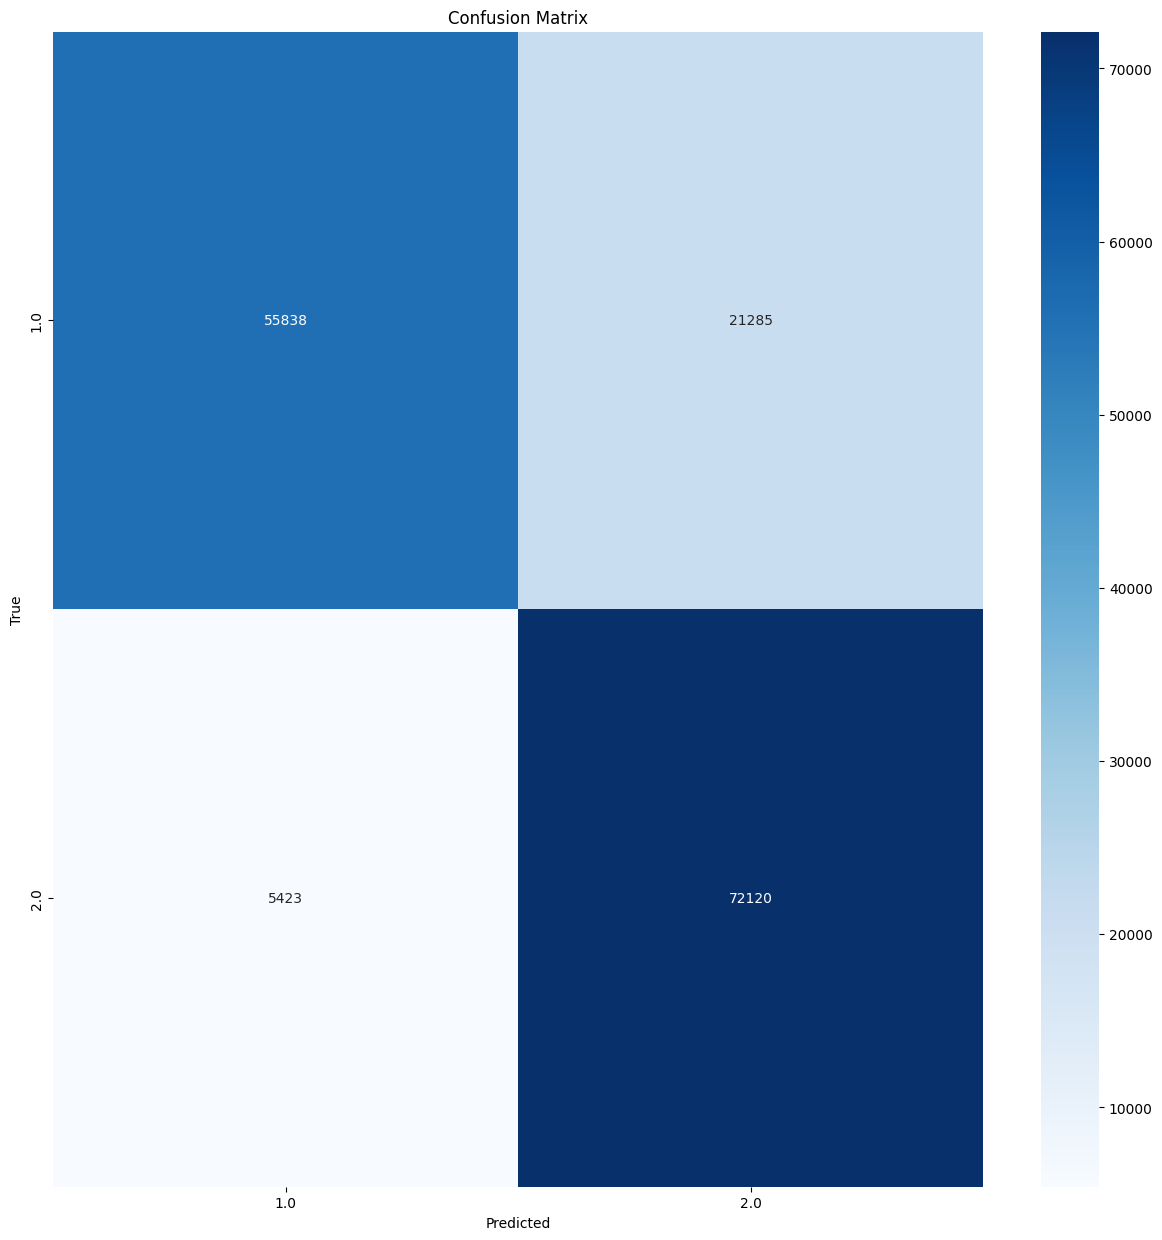

In [26]:
# Vorhersagen auf dem Testset machen (nur für die selektierten Features)

y_pred_model = softmax_model.predict(X_test)

# Validierung
accuracy = accuracy_score(y_test, y_pred_model)
print(f'Accuracy: {accuracy:.2f}')

# Confusion Matrix erstellen und anzeigen:

cm = confusion_matrix(y_test, y_pred_model)
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset['Raucher_Status'].unique() , yticklabels=dataset['Raucher_Status'].unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [27]:
# Precision berechnen:

precision = precision_score(y_test, y_pred_model, average='weighted')
print(f'Precision: {precision:.2f}')

# Recall berechnen:

recall = recall_score(y_test, y_pred_model, average='weighted')
print(f'Recall weighted: {recall:.2f}')

# F1 Score berechnen:

f1 = f1_score(y_test, y_pred_model, average='weighted')
print(f'F1 score: {f1:.2f}')

Precision: 0.84
Recall weighted: 0.83
F1 score: 0.83


Mit einer Accuracy von 83%, einer Precision von 84 %, einem Recall von 83 % und einem F1 Score von 83 % kann das Modell definitiv verwendet werden, um die gemachten Angaben der Versicherungskunden bei der Befragung zum Raucherstatus zu validieren.

Dennoch muss deulich gemacht werden, dass man sich nicht alleine auf die Ausgabewerte des Modells berufen darf.

## 5. Evaluation

## 6. Deployment

Da das Modell nun fertig trainiert und evaluiert wurden, müssten sie nun dem Business-User zur Verfügung gestellt werden.
Hierfür gibt es mehrere Möglichkeiten. 

Eine Möglichkeit wäre es, die Modelle über die 'Azure Machine Learning' - Plattform von Microsoft zu hosten, sodass sie über einen REST-Endpunkt verfügbar gemacht werden können.

Basierend auf diesem Endpunkt könnte dann eine Web-Anwendung entwickelt werden, in der die benötigten Features eingetragen werden können, sodass dann das Ergebnis der Klassifikation zurückgegeben wird.

Ein weiterer Aspekt, den es hierbei zu Berücksichtigen gibt is MLOps.
Hierbei geht es um die Maintainance der Modelle und deren Verfügbarkeit.

Es muss darauf geachtet werden, dass die Modelle dem aktuellen Stand der Daten entsprechen, was bedeutet, dass diese immer wieder neu trainiert werden sollten, sodass sich die Genauigkeit über die Zeit hält oder erhöht.

Zudem sollten sie stets verfügbar sein, wenn sie von einem Anwender benötigt werden.